In [1]:
#import lightgbm
import random
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor
import time
from sklearn.metrics import make_scorer
t = time.strftime('%m%d-%H%M', time.localtime(time.time()))
import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

깊이 튜닝

In [2]:
hyperparameters = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])

grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 12, 1),
        'max_depth' : np.arange(3,10,1) , 'colsample_bytree' :[0.8, 0.9],
        'subsample' : [0.8, 0.9]} # fix the n_estimators & eta(learning rate)

#tscv = TimeSeriesSplit(n_splits=3)
smape_score = make_scorer(SMAPE, greater_is_better=False)

for i in tqdm(np.arange(1, 101, 1)):
    train_df = pd.read_csv(f'./pretest/2train_building{i}.csv').drop(columns=['Unnamed: 0'])
    pretest_df = pd.read_csv(f'./pretest/2pretest_building{i}.csv').drop(columns=['Unnamed: 0'])
    ################################################
    #merge = pd.concat([train_df,pretest_df])
    ################################################
    #하이퍼 파라미터 튜닝 method 1
    #leaf method
    print(f"__________Buildding Number:{i} Hyperparameter Tuning__________")

    preds = np.array([])

    grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 12, 1), 'max_depth' : np.arange(3,10,1) , 'colsample_bytree' :[0.8, 0.9], 'subsample' : [0.8, 0.9]} 
    #grid_under = {}
    #합병된 데이터 사용
    y = train_df['power_consumption']
    x = train_df.drop(columns=['power_consumption'])
    #y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)
    #fit
    gcv = GridSearchCV(estimator = XGBRegressor(seed=0,tree_method="hist", gpu_id=0), param_grid=grid, scoring=smape_score
                       , cv=PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168))) ,refit=True, verbose=False)
    gcv.fit(x, y)

    best = gcv.best_estimator_
    params = gcv.best_params_

    #pred
    x_pretest = pretest_df.drop(columns=['power_consumption'])
    y_pretest = pretest_df['power_consumption']
    pred = best.predict(x_pretest)
    print("_____Best Parameters_____",params)
    print("_____SMAPE Score________", SMAPE(y_pretest, pred))
    hyperparameters = pd.concat([hyperparameters,pd.DataFrame(params,index=[i-1])],axis=0)
hyperparameters.to_csv(f'./parameters/hyperparameter_xgb_lbw{t}.csv', index=False) # save the tuned parameters


  0%|          | 0/100 [00:00<?, ?it/s]

__________Buildding Number:1 Hyperparameter Tuning__________


  1%|          | 1/100 [00:21<35:08, 21.30s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 68.87632523170177
__________Buildding Number:2 Hyperparameter Tuning__________


  2%|▏         | 2/100 [00:43<35:50, 21.95s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 58.23948850816274
__________Buildding Number:3 Hyperparameter Tuning__________


  3%|▎         | 3/100 [01:04<34:37, 21.42s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 47.58381846744296
__________Buildding Number:4 Hyperparameter Tuning__________


  4%|▍         | 4/100 [01:19<30:26, 19.03s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 50.890632209464925
__________Buildding Number:5 Hyperparameter Tuning__________


  5%|▌         | 5/100 [01:41<31:51, 20.13s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 64.84226303405417
__________Buildding Number:6 Hyperparameter Tuning__________


  6%|▌         | 6/100 [02:04<32:38, 20.84s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 58.09429162387465
__________Buildding Number:7 Hyperparameter Tuning__________


  7%|▋         | 7/100 [02:28<33:52, 21.85s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 23.3618948492012
__________Buildding Number:8 Hyperparameter Tuning__________


  8%|▊         | 8/100 [02:44<30:45, 20.06s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 52.51147670975475
__________Buildding Number:9 Hyperparameter Tuning__________


  9%|▉         | 9/100 [03:05<30:46, 20.29s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 59.552552648026726
__________Buildding Number:10 Hyperparameter Tuning__________


 10%|█         | 10/100 [03:24<30:12, 20.14s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 57.80497436889481
__________Buildding Number:11 Hyperparameter Tuning__________


 11%|█         | 11/100 [03:44<29:24, 19.82s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 50.84492961572248
__________Buildding Number:12 Hyperparameter Tuning__________


 12%|█▏        | 12/100 [04:02<28:31, 19.45s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 56.55935293600914
__________Buildding Number:13 Hyperparameter Tuning__________


 13%|█▎        | 13/100 [04:21<28:00, 19.31s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 59.05674441208134
__________Buildding Number:14 Hyperparameter Tuning__________


 14%|█▍        | 14/100 [04:45<29:31, 20.60s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.59794786405092
__________Buildding Number:15 Hyperparameter Tuning__________


 15%|█▌        | 15/100 [05:02<27:49, 19.65s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 51.64577929188869
__________Buildding Number:16 Hyperparameter Tuning__________


 16%|█▌        | 16/100 [05:22<27:48, 19.87s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 61.59586589400398
__________Buildding Number:17 Hyperparameter Tuning__________


 17%|█▋        | 17/100 [05:45<28:28, 20.59s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 54.85034888128747
__________Buildding Number:18 Hyperparameter Tuning__________


 18%|█▊        | 18/100 [06:05<28:06, 20.57s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 62.75960730629364
__________Buildding Number:19 Hyperparameter Tuning__________


 19%|█▉        | 19/100 [06:28<28:33, 21.16s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 61.31368659652699
__________Buildding Number:20 Hyperparameter Tuning__________


 20%|██        | 20/100 [06:49<28:17, 21.22s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 53.53933647176365
__________Buildding Number:21 Hyperparameter Tuning__________


 21%|██        | 21/100 [07:10<27:48, 21.12s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 54.512544632006176
__________Buildding Number:22 Hyperparameter Tuning__________


 22%|██▏       | 22/100 [07:29<26:34, 20.44s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.83183680798245
__________Buildding Number:23 Hyperparameter Tuning__________


 23%|██▎       | 23/100 [07:45<24:38, 19.21s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 51.37951977238117
__________Buildding Number:24 Hyperparameter Tuning__________


 24%|██▍       | 24/100 [08:05<24:23, 19.26s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 55.26156968237676
__________Buildding Number:25 Hyperparameter Tuning__________


 25%|██▌       | 25/100 [08:24<24:15, 19.40s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 51.119609117508396
__________Buildding Number:26 Hyperparameter Tuning__________


 26%|██▌       | 26/100 [08:44<23:53, 19.38s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 48.775863326377895
__________Buildding Number:27 Hyperparameter Tuning__________


 27%|██▋       | 27/100 [09:02<23:04, 18.96s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 53.67343512207557
__________Buildding Number:28 Hyperparameter Tuning__________


 28%|██▊       | 28/100 [09:22<23:05, 19.24s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 38.817704292107386
__________Buildding Number:29 Hyperparameter Tuning__________


 29%|██▉       | 29/100 [09:40<22:32, 19.05s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.15127235159463
__________Buildding Number:30 Hyperparameter Tuning__________


 30%|███       | 30/100 [10:03<23:30, 20.15s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 9, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 49.691141571537564
__________Buildding Number:31 Hyperparameter Tuning__________


 31%|███       | 31/100 [10:22<22:49, 19.85s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.67911011353554
__________Buildding Number:32 Hyperparameter Tuning__________


 32%|███▏      | 32/100 [10:34<19:39, 17.34s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.85057660983981
__________Buildding Number:33 Hyperparameter Tuning__________


 33%|███▎      | 33/100 [10:45<17:17, 15.48s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.494344729732966
__________Buildding Number:34 Hyperparameter Tuning__________


 34%|███▍      | 34/100 [10:57<15:50, 14.40s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 48.126184556647644
__________Buildding Number:35 Hyperparameter Tuning__________


 35%|███▌      | 35/100 [11:08<14:30, 13.39s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.22472436360645
__________Buildding Number:36 Hyperparameter Tuning__________


 36%|███▌      | 36/100 [11:18<13:22, 12.54s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.981521234995945
__________Buildding Number:37 Hyperparameter Tuning__________


 37%|███▋      | 37/100 [11:40<16:10, 15.40s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 53.89157768344951
__________Buildding Number:38 Hyperparameter Tuning__________


 38%|███▊      | 38/100 [12:03<18:09, 17.58s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 56.66879945922275
__________Buildding Number:39 Hyperparameter Tuning__________


 39%|███▉      | 39/100 [12:24<19:00, 18.70s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 50.431128865153056
__________Buildding Number:40 Hyperparameter Tuning__________


 40%|████      | 40/100 [12:50<20:43, 20.72s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 57.26471924338951
__________Buildding Number:41 Hyperparameter Tuning__________


 41%|████      | 41/100 [13:12<20:49, 21.17s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 54.32691025917464
__________Buildding Number:42 Hyperparameter Tuning__________


 42%|████▏     | 42/100 [13:34<20:45, 21.47s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 50.432256179654324
__________Buildding Number:43 Hyperparameter Tuning__________


 43%|████▎     | 43/100 [13:55<20:10, 21.23s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 55.62500380285315
__________Buildding Number:44 Hyperparameter Tuning__________


 44%|████▍     | 44/100 [14:15<19:32, 20.94s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 48.41476960770619
__________Buildding Number:45 Hyperparameter Tuning__________


 45%|████▌     | 45/100 [14:33<18:28, 20.15s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 56.487192107157995
__________Buildding Number:46 Hyperparameter Tuning__________


 46%|████▌     | 46/100 [14:53<17:56, 19.94s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 61.60638897953636
__________Buildding Number:47 Hyperparameter Tuning__________


 47%|████▋     | 47/100 [15:10<17:02, 19.29s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 53.768136865111565
__________Buildding Number:48 Hyperparameter Tuning__________


 48%|████▊     | 48/100 [15:29<16:34, 19.13s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 55.705820537851366
__________Buildding Number:49 Hyperparameter Tuning__________


 49%|████▉     | 49/100 [15:47<15:48, 18.60s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 57.51558833788288
__________Buildding Number:50 Hyperparameter Tuning__________


 50%|█████     | 50/100 [16:04<15:10, 18.20s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 60.12702242990389
__________Buildding Number:51 Hyperparameter Tuning__________


 51%|█████     | 51/100 [16:23<15:05, 18.48s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 52.03668098626508
__________Buildding Number:52 Hyperparameter Tuning__________


 52%|█████▏    | 52/100 [16:43<15:02, 18.80s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 54.517541322662396
__________Buildding Number:53 Hyperparameter Tuning__________


 53%|█████▎    | 53/100 [17:07<16:09, 20.63s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 58.891336408772496
__________Buildding Number:54 Hyperparameter Tuning__________


 54%|█████▍    | 54/100 [17:32<16:48, 21.92s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 61.7946081240008
__________Buildding Number:55 Hyperparameter Tuning__________


 55%|█████▌    | 55/100 [17:47<14:43, 19.63s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.424409482939794
__________Buildding Number:56 Hyperparameter Tuning__________


 56%|█████▌    | 56/100 [18:00<12:59, 17.71s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.25323472337406
__________Buildding Number:57 Hyperparameter Tuning__________


 57%|█████▋    | 57/100 [18:21<13:31, 18.86s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 55.098675105446716
__________Buildding Number:58 Hyperparameter Tuning__________


 58%|█████▊    | 58/100 [18:33<11:43, 16.75s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.22125778766647
__________Buildding Number:59 Hyperparameter Tuning__________


 59%|█████▉    | 59/100 [18:56<12:36, 18.44s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 47.68871242762858
__________Buildding Number:60 Hyperparameter Tuning__________


 60%|██████    | 60/100 [19:16<12:36, 18.92s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 55.31228707901326
__________Buildding Number:61 Hyperparameter Tuning__________


 61%|██████    | 61/100 [19:38<12:55, 19.89s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 56.693745045619075
__________Buildding Number:62 Hyperparameter Tuning__________


 62%|██████▏   | 62/100 [20:00<12:58, 20.50s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 63.35035413249025
__________Buildding Number:63 Hyperparameter Tuning__________


 63%|██████▎   | 63/100 [20:23<13:12, 21.41s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 63.20037936127943
__________Buildding Number:64 Hyperparameter Tuning__________


 64%|██████▍   | 64/100 [20:44<12:47, 21.33s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 54.47734821796377
__________Buildding Number:65 Hyperparameter Tuning__________


 65%|██████▌   | 65/100 [21:08<12:49, 21.99s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 79.97511843781322
__________Buildding Number:66 Hyperparameter Tuning__________


 66%|██████▌   | 66/100 [21:27<11:57, 21.11s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 56.39006513443876
__________Buildding Number:67 Hyperparameter Tuning__________


 67%|██████▋   | 67/100 [21:48<11:33, 21.02s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 51.76110026843755
__________Buildding Number:68 Hyperparameter Tuning__________


 68%|██████▊   | 68/100 [22:09<11:15, 21.12s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 57.38107862121984
__________Buildding Number:69 Hyperparameter Tuning__________


 69%|██████▉   | 69/100 [22:28<10:30, 20.33s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 52.102591342670884
__________Buildding Number:70 Hyperparameter Tuning__________


 70%|███████   | 70/100 [22:50<10:25, 20.87s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 50.892013578660006
__________Buildding Number:71 Hyperparameter Tuning__________


 71%|███████   | 71/100 [23:09<09:52, 20.44s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 68.14169365239395
__________Buildding Number:72 Hyperparameter Tuning__________


 72%|███████▏  | 72/100 [23:26<09:00, 19.29s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 61.51923237755116
__________Buildding Number:73 Hyperparameter Tuning__________


 73%|███████▎  | 73/100 [23:43<08:26, 18.75s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 59.481096711650814
__________Buildding Number:74 Hyperparameter Tuning__________


 74%|███████▍  | 74/100 [24:03<08:14, 19.03s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 61.01047865189173
__________Buildding Number:75 Hyperparameter Tuning__________


 75%|███████▌  | 75/100 [24:22<07:58, 19.13s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 54.140072604076344
__________Buildding Number:76 Hyperparameter Tuning__________


 76%|███████▌  | 76/100 [24:41<07:35, 18.97s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 57.95610256922399
__________Buildding Number:77 Hyperparameter Tuning__________


 77%|███████▋  | 77/100 [25:00<07:19, 19.10s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 53.13589585419872
__________Buildding Number:78 Hyperparameter Tuning__________


 78%|███████▊  | 78/100 [25:21<07:10, 19.58s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 59.54124538671114
__________Buildding Number:79 Hyperparameter Tuning__________


 79%|███████▉  | 79/100 [25:41<06:55, 19.76s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 53.922213549581606
__________Buildding Number:80 Hyperparameter Tuning__________


 80%|████████  | 80/100 [26:03<06:47, 20.39s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 61.815892961346705
__________Buildding Number:81 Hyperparameter Tuning__________


 81%|████████  | 81/100 [26:24<06:31, 20.63s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 57.47661238161504
__________Buildding Number:82 Hyperparameter Tuning__________


 82%|████████▏ | 82/100 [26:46<06:18, 21.02s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 62.57758852329439
__________Buildding Number:83 Hyperparameter Tuning__________


 83%|████████▎ | 83/100 [27:08<05:59, 21.17s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 56.75090309125998
__________Buildding Number:84 Hyperparameter Tuning__________


 84%|████████▍ | 84/100 [27:29<05:39, 21.20s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 57.92257601067798
__________Buildding Number:85 Hyperparameter Tuning__________


 85%|████████▌ | 85/100 [27:48<05:05, 20.39s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 56.4494617478498
__________Buildding Number:86 Hyperparameter Tuning__________


 86%|████████▌ | 86/100 [28:10<04:54, 21.04s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 52.101747960707016
__________Buildding Number:87 Hyperparameter Tuning__________


 87%|████████▋ | 87/100 [28:35<04:48, 22.21s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 72.74483724067167
__________Buildding Number:88 Hyperparameter Tuning__________


 88%|████████▊ | 88/100 [29:00<04:35, 22.96s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 9, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 52.77940468724382
__________Buildding Number:89 Hyperparameter Tuning__________


 89%|████████▉ | 89/100 [29:24<04:18, 23.49s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 55.89361895542945
__________Buildding Number:90 Hyperparameter Tuning__________


 90%|█████████ | 90/100 [29:50<04:00, 24.04s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 59.57401744536705
__________Buildding Number:91 Hyperparameter Tuning__________


 91%|█████████ | 91/100 [30:12<03:32, 23.57s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 53.608150685718975
__________Buildding Number:92 Hyperparameter Tuning__________


 92%|█████████▏| 92/100 [30:33<03:02, 22.79s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 45.61689274913157
__________Buildding Number:93 Hyperparameter Tuning__________


 93%|█████████▎| 93/100 [30:54<02:34, 22.04s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 58.04084315154175
__________Buildding Number:94 Hyperparameter Tuning__________


 94%|█████████▍| 94/100 [31:15<02:11, 21.94s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 58.125593899938735
__________Buildding Number:95 Hyperparameter Tuning__________


 95%|█████████▌| 95/100 [31:38<01:51, 22.26s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 47.38807280856884
__________Buildding Number:96 Hyperparameter Tuning__________


 96%|█████████▌| 96/100 [31:59<01:26, 21.66s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 59.658469457689435
__________Buildding Number:97 Hyperparameter Tuning__________


 97%|█████████▋| 97/100 [32:19<01:04, 21.44s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 59.186139086679866
__________Buildding Number:98 Hyperparameter Tuning__________


 98%|█████████▊| 98/100 [32:43<00:44, 22.03s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 54.44723196258093
__________Buildding Number:99 Hyperparameter Tuning__________


 99%|█████████▉| 99/100 [33:04<00:21, 21.84s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 54.15704208525418
__________Buildding Number:100 Hyperparameter Tuning__________


100%|██████████| 100/100 [33:26<00:00, 20.06s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 56.769472088650815


n_estimators 튜닝

In [3]:
#n_estimators
xgb_params = pd.read_csv(f'./parameters/hyperparameter_xgb_lbw{t}.csv')
scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list
for i in tqdm(range(100)):
    train_df = pd.read_csv(f'./pretest/2train_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    pretest_df = pd.read_csv(f'./pretest/2pretest_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    ################################################
    t_y = train_df['power_consumption']
    t_x = train_df.drop(['power_consumption'], axis=1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = t_y, X = t_x, test_size = 168)
    
    p_y = pretest_df['power_consumption']
    p_x = pretest_df.drop(['power_consumption'], axis=1)

    xgb_reg = XGBRegressor(n_estimators = 10000, tree_method="hist",  gpu_id=0, 
                           eta = 0.01, 
                           min_child_weight = xgb_params.iloc[i, 2],
                           max_depth = xgb_params.iloc[i, 3], 
                           colsample_bytree = xgb_params.iloc[i, 4],
                           subsample = xgb_params.iloc[i, 5], 
                           seed=0)
    xgb_reg.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정

    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train),(x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
    
    y_pred = xgb_reg.predict(p_x)
    pred = pd.Series(y_pred)
    
    sm = SMAPE(p_y, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration+1) ## 실제 best iteration은 이 값에 +1 해주어야 함.
hyperparameters['best_it'] = best_it

100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


alpha튜닝

In [5]:
xgb_params = pd.read_csv(f'./parameters/hyperparameter_xgb_lbw0810-2147.csv')
#alpha
alpha_list = []
smape_list = []
for i in tqdm(range(100)):
    train_df = pd.read_csv(f'./pretest/2train_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    pretest_df = pd.read_csv(f'./pretest/2pretest_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    
    ################################################
    t_y = train_df['power_consumption']
    t_x = train_df.drop(['power_consumption'], axis=1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = t_y, X = t_x, test_size = 168)
    
    
    p_y = pretest_df['power_consumption']
    p_x = pretest_df.drop(['power_consumption'], axis=1)

    xgb = XGBRegressor(seed = 0, tree_method="hist",  gpu_id=0,
                      n_estimators = best_it[i], 
                      eta = 0.01, 
                      min_child_weight = xgb_params.iloc[i, 2],
                      max_depth = xgb_params.iloc[i, 3], 
                      colsample_bytree = xgb_params.iloc[i, 4], 
                      subsample = xgb_params.iloc[i, 5])

    xgb.fit(x_train, y_train ,verbose=False)
    pred0 = xgb.predict(x_valid)
    best_alpha = 0
    score0 = SMAPE(y_valid,pred0)

    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
        xgb = XGBRegressor(seed = 0,
                      n_estimators =  best_it[i], eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                      max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4], subsample = xgb_params.iloc[i, 5])
        xgb.set_params(**{'objective' : weighted_mse(j)})

        xgb.fit(x_train, y_train,verbose=False)
        
        pred1 = xgb.predict(x_valid)
        score1 = SMAPE(y_valid, pred1)
        if score1 < score0: 
            best_alpha = j
            score0 = score1

    alpha_list.append(best_alpha)
    smape_list.append(score0)
    
    print("building {} || best score : {} || alpha : {}".format(i+1, score0, best_alpha))
    
    
hyperparameters['alpha'] = alpha_list

  1%|          | 1/100 [00:06<10:38,  6.45s/it]

building 1 || best score : 5.361085129610521 || alpha : 100


  2%|▏         | 2/100 [00:14<11:35,  7.10s/it]

building 2 || best score : 8.594058447416149 || alpha : 1


  3%|▎         | 3/100 [00:19<09:59,  6.18s/it]

building 3 || best score : 12.61232592995597 || alpha : 7


  4%|▍         | 4/100 [00:27<11:01,  6.89s/it]

building 4 || best score : 3.144129594641697 || alpha : 1


  5%|▌         | 5/100 [00:36<12:17,  7.76s/it]

building 5 || best score : 6.974580784076366 || alpha : 0


  6%|▌         | 6/100 [00:46<13:09,  8.40s/it]

building 6 || best score : 3.54439051411431 || alpha : 0


  7%|▋         | 7/100 [00:50<10:48,  6.98s/it]

building 7 || best score : 8.478523660123892 || alpha : 3


  8%|▊         | 8/100 [01:02<13:21,  8.72s/it]

building 8 || best score : 4.955104531679244 || alpha : 50


  9%|▉         | 9/100 [01:10<12:49,  8.46s/it]

building 9 || best score : 5.392142866837303 || alpha : 3


 10%|█         | 10/100 [01:18<12:21,  8.24s/it]

building 10 || best score : 6.112758971090161 || alpha : 100


 11%|█         | 11/100 [01:23<10:43,  7.23s/it]

building 11 || best score : 3.4854068014235646 || alpha : 75


 12%|█▏        | 12/100 [01:33<12:02,  8.21s/it]

building 12 || best score : 3.1228879635457436 || alpha : 100


 13%|█▎        | 13/100 [01:46<13:53,  9.58s/it]

building 13 || best score : 6.922029031602198 || alpha : 50


 14%|█▍        | 14/100 [01:57<14:17,  9.98s/it]

building 14 || best score : 14.988586398783433 || alpha : 25


 15%|█▌        | 15/100 [02:01<11:47,  8.33s/it]

building 15 || best score : 4.632746392138429 || alpha : 75


 16%|█▌        | 16/100 [02:10<11:57,  8.54s/it]

building 16 || best score : 3.4578981731365226 || alpha : 10


 17%|█▋        | 17/100 [02:14<09:56,  7.19s/it]

building 17 || best score : 7.592557366521997 || alpha : 1


 18%|█▊        | 18/100 [02:18<08:26,  6.18s/it]

building 18 || best score : 9.325832041365576 || alpha : 1


 19%|█▉        | 19/100 [02:22<07:15,  5.37s/it]

building 19 || best score : 11.147325768165265 || alpha : 50


 20%|██        | 20/100 [02:26<06:42,  5.03s/it]

building 20 || best score : 11.21495541207201 || alpha : 10


 21%|██        | 21/100 [02:31<06:41,  5.08s/it]

building 21 || best score : 10.356832337106093 || alpha : 1


 22%|██▏       | 22/100 [02:36<06:43,  5.17s/it]

building 22 || best score : 4.2254022910337765 || alpha : 0


 23%|██▎       | 23/100 [02:41<06:32,  5.10s/it]

building 23 || best score : 6.941881590252582 || alpha : 10


 24%|██▍       | 24/100 [02:46<06:16,  4.95s/it]

building 24 || best score : 7.918691422519766 || alpha : 25


 25%|██▌       | 25/100 [02:53<06:49,  5.46s/it]

building 25 || best score : 3.2240082891059236 || alpha : 100


 26%|██▌       | 26/100 [02:57<06:15,  5.07s/it]

building 26 || best score : 7.081822488958921 || alpha : 25


 27%|██▋       | 27/100 [03:02<06:07,  5.04s/it]

building 27 || best score : 4.227043178543754 || alpha : 10


 28%|██▊       | 28/100 [03:06<05:46,  4.81s/it]

building 28 || best score : 8.53143421995288 || alpha : 0


 29%|██▉       | 29/100 [03:09<05:12,  4.40s/it]

building 29 || best score : 8.131121859937512 || alpha : 0


 30%|███       | 30/100 [03:15<05:37,  4.82s/it]

building 30 || best score : 10.216092979890632 || alpha : 50


 31%|███       | 31/100 [03:19<05:07,  4.46s/it]

building 31 || best score : 8.534089551823364 || alpha : 25


 32%|███▏      | 32/100 [03:25<05:46,  5.09s/it]

building 32 || best score : 0.2768314521464885 || alpha : 3


 33%|███▎      | 33/100 [03:33<06:24,  5.74s/it]

building 33 || best score : 0.3835066840044754 || alpha : 0


 34%|███▍      | 34/100 [03:39<06:36,  6.01s/it]

building 34 || best score : 0.5565268159836471 || alpha : 5


 35%|███▌      | 35/100 [03:46<06:47,  6.26s/it]

building 35 || best score : 0.4128026220806293 || alpha : 1


 36%|███▌      | 36/100 [04:00<08:58,  8.42s/it]

building 36 || best score : 1.0768194479531663 || alpha : 100


 37%|███▋      | 37/100 [04:07<08:35,  8.18s/it]

building 37 || best score : 3.968441565910825 || alpha : 50


 38%|███▊      | 38/100 [04:21<10:02,  9.71s/it]

building 38 || best score : 4.154163075317831 || alpha : 25


 39%|███▉      | 39/100 [04:34<11:09, 10.98s/it]

building 39 || best score : 5.322535694805854 || alpha : 1


 40%|████      | 40/100 [04:40<09:21,  9.36s/it]

building 40 || best score : 13.081492996089164 || alpha : 3


 41%|████      | 41/100 [04:48<08:56,  9.09s/it]

building 41 || best score : 7.324830036973594 || alpha : 3


 42%|████▏     | 42/100 [04:57<08:40,  8.98s/it]

building 42 || best score : 2.9024044734058174 || alpha : 100


 43%|████▎     | 43/100 [05:03<07:38,  8.04s/it]

building 43 || best score : 4.161839230396382 || alpha : 1


 44%|████▍     | 44/100 [05:20<10:06, 10.83s/it]

building 44 || best score : 6.999531686971362 || alpha : 0


 45%|████▌     | 45/100 [05:29<09:24, 10.27s/it]

building 45 || best score : 3.5510655439813434 || alpha : 50


 46%|████▌     | 46/100 [05:35<07:58,  8.86s/it]

building 46 || best score : 5.915629843509848 || alpha : 25


 47%|████▋     | 47/100 [05:40<06:46,  7.67s/it]

building 47 || best score : 5.515112192042164 || alpha : 1


 48%|████▊     | 48/100 [05:46<06:12,  7.17s/it]

building 48 || best score : 4.323520443590811 || alpha : 50


 49%|████▉     | 49/100 [05:55<06:42,  7.90s/it]

building 49 || best score : 4.491809925335135 || alpha : 75


 50%|█████     | 50/100 [06:02<06:11,  7.42s/it]

building 50 || best score : 3.3141402467816157 || alpha : 3


 51%|█████     | 51/100 [06:08<05:45,  7.06s/it]

building 51 || best score : 4.310143545469909 || alpha : 25


 52%|█████▏    | 52/100 [06:13<05:16,  6.60s/it]

building 52 || best score : 5.346216022366044 || alpha : 50


 53%|█████▎    | 53/100 [06:17<04:23,  5.60s/it]

building 53 || best score : 16.008075186755693 || alpha : 0


 54%|█████▍    | 54/100 [06:19<03:34,  4.66s/it]

building 54 || best score : 22.769304053385458 || alpha : 0


 55%|█████▌    | 55/100 [06:26<04:01,  5.36s/it]

building 55 || best score : 1.5479384491329315 || alpha : 3


 56%|█████▌    | 56/100 [06:33<04:14,  5.79s/it]

building 56 || best score : 0.9045946271848139 || alpha : 0


 57%|█████▋    | 57/100 [06:41<04:32,  6.33s/it]

building 57 || best score : 6.399153876457243 || alpha : 0


 58%|█████▊    | 58/100 [06:48<04:40,  6.68s/it]

building 58 || best score : 0.5764391139449646 || alpha : 3


 59%|█████▉    | 59/100 [06:57<05:01,  7.36s/it]

building 59 || best score : 9.72273943540497 || alpha : 75


 60%|██████    | 60/100 [07:13<06:42, 10.07s/it]

building 60 || best score : 8.366045593056844 || alpha : 0


 61%|██████    | 61/100 [07:19<05:35,  8.61s/it]

building 61 || best score : 4.894234055150594 || alpha : 100


 62%|██████▏   | 62/100 [07:24<04:45,  7.52s/it]

building 62 || best score : 4.9129413877422055 || alpha : 100


 63%|██████▎   | 63/100 [07:28<04:05,  6.64s/it]

building 63 || best score : 4.186420120894869 || alpha : 50


 64%|██████▍   | 64/100 [07:33<03:35,  5.99s/it]

building 64 || best score : 3.68629612691982 || alpha : 7


 65%|██████▌   | 65/100 [07:46<04:47,  8.21s/it]

building 65 || best score : 8.163238776474069 || alpha : 50


 66%|██████▌   | 66/100 [07:52<04:20,  7.66s/it]

building 66 || best score : 3.529604015008366 || alpha : 25


 67%|██████▋   | 67/100 [07:58<03:56,  7.16s/it]

building 67 || best score : 5.5330675582035385 || alpha : 1


 68%|██████▊   | 68/100 [08:04<03:30,  6.57s/it]

building 68 || best score : 4.187574238932511 || alpha : 0


 69%|██████▉   | 69/100 [08:09<03:08,  6.08s/it]

building 69 || best score : 6.8245792654498185 || alpha : 100


 70%|███████   | 70/100 [08:16<03:15,  6.51s/it]

building 70 || best score : 6.400855164769543 || alpha : 0


 71%|███████   | 71/100 [08:20<02:45,  5.71s/it]

building 71 || best score : 9.971909571895191 || alpha : 7


 72%|███████▏  | 72/100 [08:24<02:25,  5.21s/it]

building 72 || best score : 6.685211854158263 || alpha : 3


 73%|███████▎  | 73/100 [08:31<02:32,  5.65s/it]

building 73 || best score : 4.925389002549963 || alpha : 7


 74%|███████▍  | 74/100 [08:35<02:18,  5.32s/it]

building 74 || best score : 14.845806018173322 || alpha : 75


 75%|███████▌  | 75/100 [08:41<02:19,  5.57s/it]

building 75 || best score : 4.963467192073718 || alpha : 100


 76%|███████▌  | 76/100 [08:47<02:17,  5.72s/it]

building 76 || best score : 7.229763080547742 || alpha : 1


 77%|███████▋  | 77/100 [08:53<02:12,  5.78s/it]

building 77 || best score : 4.560737275013247 || alpha : 3


 78%|███████▊  | 78/100 [09:00<02:11,  5.97s/it]

building 78 || best score : 10.435289291656158 || alpha : 100


 79%|███████▉  | 79/100 [09:04<01:57,  5.59s/it]

building 79 || best score : 5.049800465511762 || alpha : 0


 80%|████████  | 80/100 [09:09<01:43,  5.17s/it]

building 80 || best score : 15.31300040325617 || alpha : 50


 81%|████████  | 81/100 [09:25<02:42,  8.53s/it]

building 81 || best score : 3.6182175926349243 || alpha : 10


 82%|████████▏ | 82/100 [09:29<02:08,  7.15s/it]

building 82 || best score : 12.978997406610759 || alpha : 3


 83%|████████▎ | 83/100 [09:33<01:46,  6.25s/it]

building 83 || best score : 16.414295510505685 || alpha : 0


 84%|████████▍ | 84/100 [09:39<01:37,  6.07s/it]

building 84 || best score : 11.534034317808391 || alpha : 100


 85%|████████▌ | 85/100 [09:49<01:49,  7.31s/it]

building 85 || best score : 2.6585472095038623 || alpha : 0


 86%|████████▌ | 86/100 [10:01<02:00,  8.60s/it]

building 86 || best score : 30.45916541498249 || alpha : 100


 87%|████████▋ | 87/100 [10:05<01:36,  7.40s/it]

building 87 || best score : 10.484546143304971 || alpha : 3


 88%|████████▊ | 88/100 [10:11<01:23,  6.94s/it]

building 88 || best score : 15.445617300964631 || alpha : 0


 89%|████████▉ | 89/100 [10:16<01:10,  6.44s/it]

building 89 || best score : 16.770536147348647 || alpha : 0


 90%|█████████ | 90/100 [10:20<00:56,  5.65s/it]

building 90 || best score : 21.095847546731115 || alpha : 3


 91%|█████████ | 91/100 [10:24<00:46,  5.20s/it]

building 91 || best score : 8.569481145320559 || alpha : 3


 92%|█████████▏| 92/100 [10:28<00:38,  4.76s/it]

building 92 || best score : 11.241514619832374 || alpha : 0


 93%|█████████▎| 93/100 [10:34<00:35,  5.08s/it]

building 93 || best score : 2.817120164459352 || alpha : 100


 94%|█████████▍| 94/100 [10:42<00:36,  6.07s/it]

building 94 || best score : 5.47126798138506 || alpha : 25


 95%|█████████▌| 95/100 [10:46<00:26,  5.32s/it]

building 95 || best score : 13.643705044438484 || alpha : 100


 96%|█████████▌| 96/100 [10:52<00:22,  5.66s/it]

building 96 || best score : 2.531551661390874 || alpha : 25


 97%|█████████▋| 97/100 [11:07<00:25,  8.46s/it]

building 97 || best score : 4.425184797709858 || alpha : 5


 98%|█████████▊| 98/100 [11:14<00:15,  7.93s/it]

building 98 || best score : 9.741254375954298 || alpha : 0


 99%|█████████▉| 99/100 [11:22<00:08,  8.02s/it]

building 99 || best score : 3.68186819476004 || alpha : 3


100%|██████████| 100/100 [11:29<00:00,  6.90s/it]

building 100 || best score : 4.225138321571541 || alpha : 0


In [6]:
hyperparameters.to_csv(f'./parameters/hyperparameter_xgb_lbw{t}.csv')

  0%|          | 0/100 [00:00<?, ?it/s]

SMAPE: 26.140564899022458


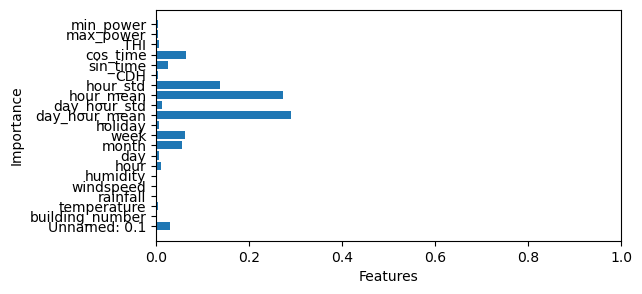

  1%|          | 1/100 [00:04<06:37,  4.02s/it]

SMAPE: 18.83443672845635


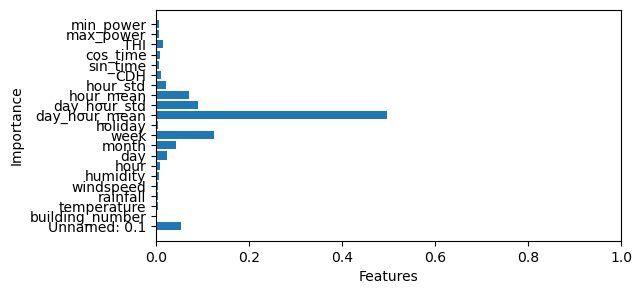

  2%|▏         | 2/100 [00:07<06:20,  3.88s/it]

SMAPE: 10.267577211202664


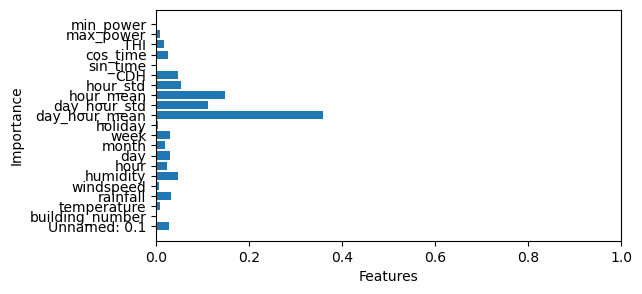

  3%|▎         | 3/100 [00:10<05:24,  3.35s/it]

SMAPE: 9.516467981967617


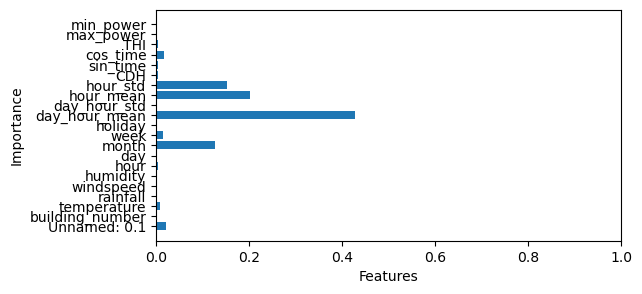

  4%|▍         | 4/100 [00:14<05:47,  3.62s/it]

SMAPE: 24.120577991939008


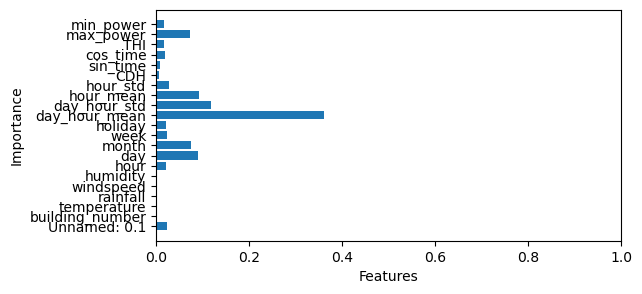

  5%|▌         | 5/100 [00:16<04:45,  3.00s/it]

SMAPE: 17.152578440334157


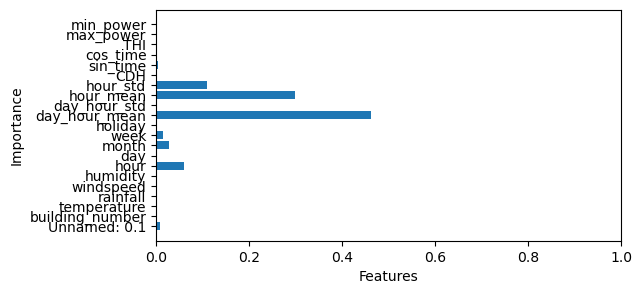

  6%|▌         | 6/100 [00:19<04:31,  2.89s/it]

SMAPE: 19.2153528642738


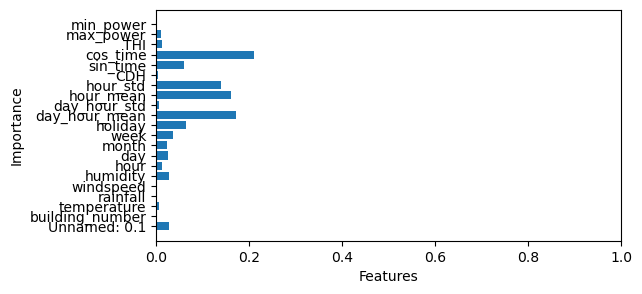

  7%|▋         | 7/100 [00:21<04:10,  2.69s/it]

SMAPE: 8.176711014631199


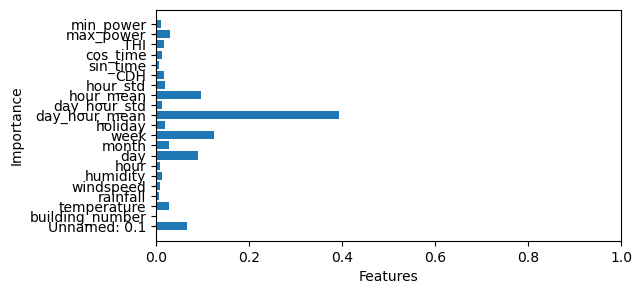

  8%|▊         | 8/100 [00:28<06:23,  4.17s/it]

SMAPE: 16.200563608040838


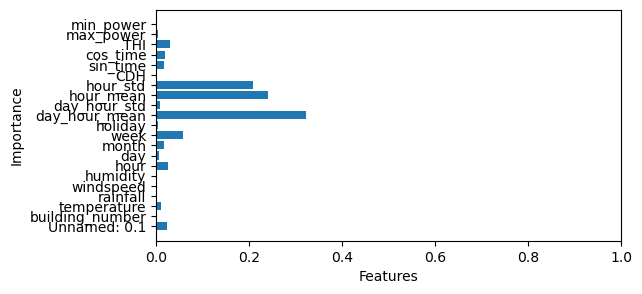

  9%|▉         | 9/100 [00:33<06:33,  4.33s/it]

SMAPE: 8.498211931142555


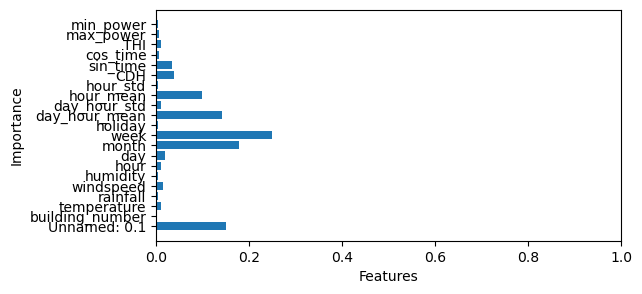

 10%|█         | 10/100 [00:37<06:31,  4.36s/it]

SMAPE: 7.838641239380766


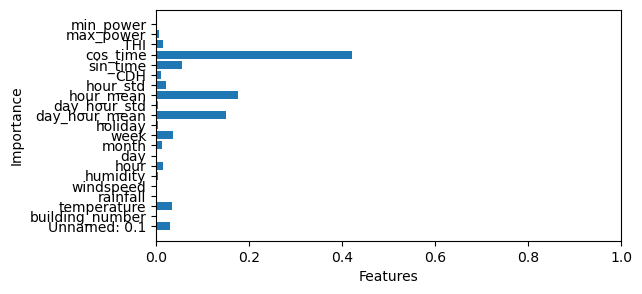

 11%|█         | 11/100 [00:40<05:53,  3.97s/it]

SMAPE: 11.75347351005127


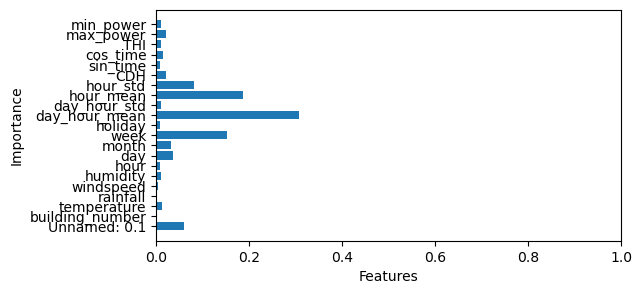

 12%|█▏        | 12/100 [00:47<07:08,  4.87s/it]

SMAPE: 15.755971801526684


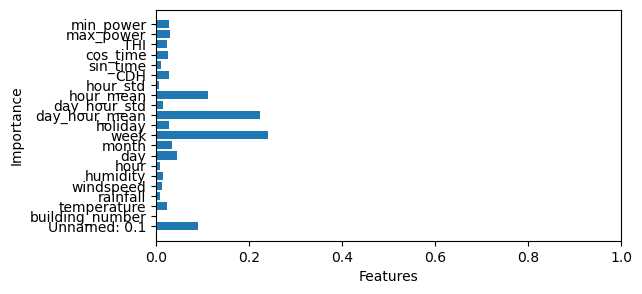

 13%|█▎        | 13/100 [00:54<08:01,  5.54s/it]

SMAPE: 19.259832797766553


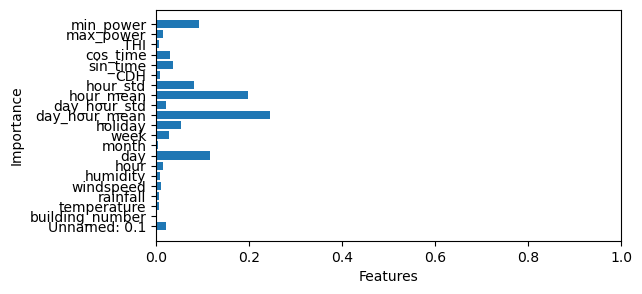

 14%|█▍        | 14/100 [01:01<08:27,  5.90s/it]

SMAPE: 10.568459433137981


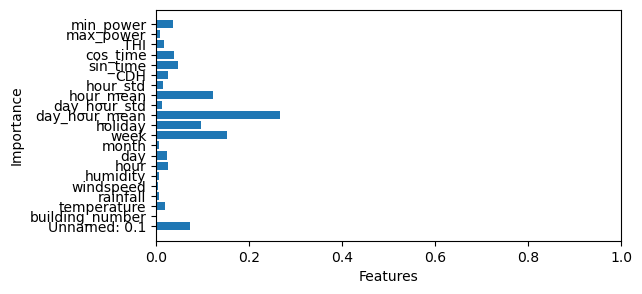

 15%|█▌        | 15/100 [01:05<07:29,  5.29s/it]

SMAPE: 18.085162914212976


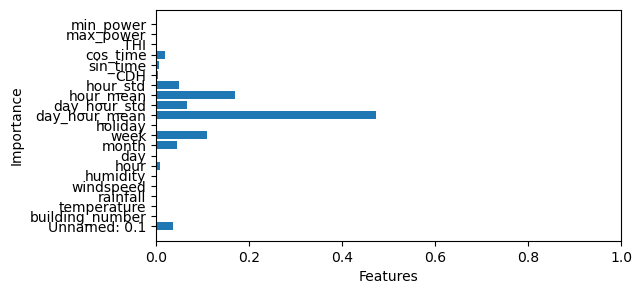

 16%|█▌        | 16/100 [01:13<08:21,  5.97s/it]

SMAPE: 16.86865610355407


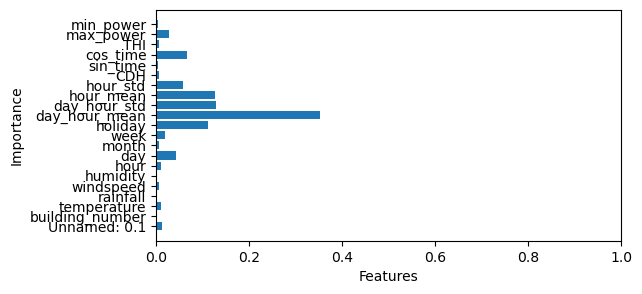

 17%|█▋        | 17/100 [01:15<06:48,  4.92s/it]

SMAPE: 28.205109957493807


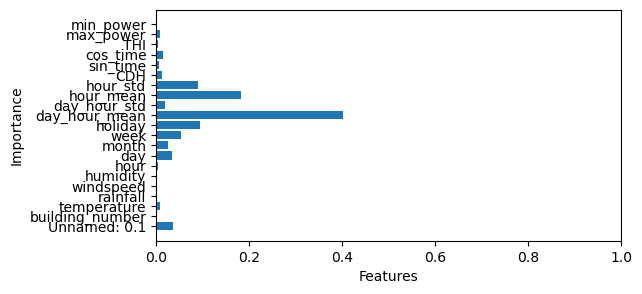

 18%|█▊        | 18/100 [01:18<05:55,  4.33s/it]

SMAPE: 27.173348980538265


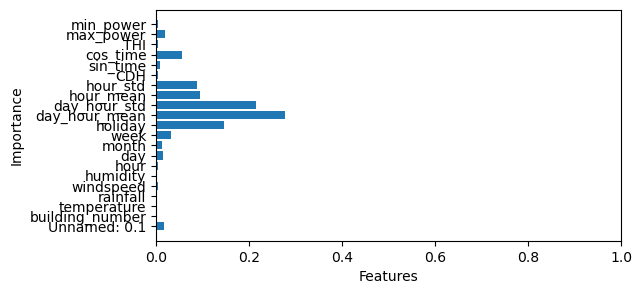

 19%|█▉        | 19/100 [01:22<05:30,  4.08s/it]

SMAPE: 15.409938980127865


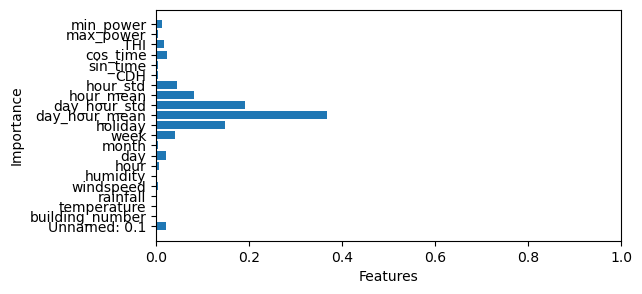

 20%|██        | 20/100 [01:25<05:01,  3.77s/it]

SMAPE: 16.36211705929624


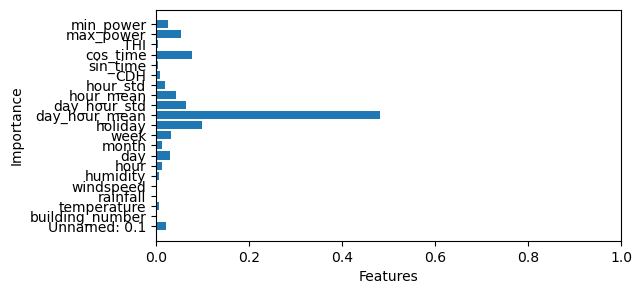

 21%|██        | 21/100 [01:28<04:44,  3.61s/it]

SMAPE: 6.301114553126136


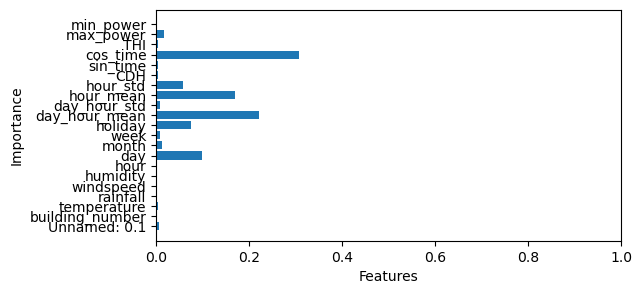

 22%|██▏       | 22/100 [01:29<03:47,  2.92s/it]

SMAPE: 11.94511198087348


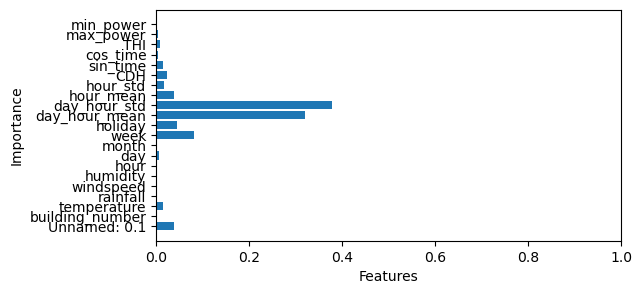

 23%|██▎       | 23/100 [01:32<03:42,  2.89s/it]

SMAPE: 16.260985666619664


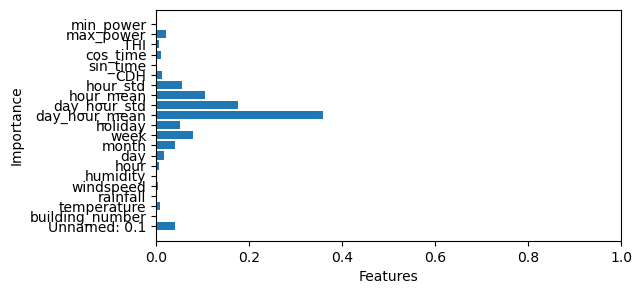

 24%|██▍       | 24/100 [01:35<03:38,  2.88s/it]

SMAPE: 8.774084308769632


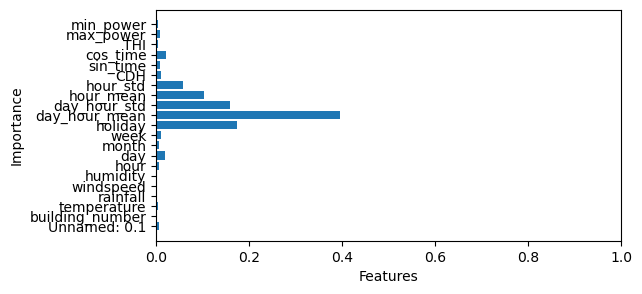

 25%|██▌       | 25/100 [01:40<04:19,  3.46s/it]

SMAPE: 8.167339997521204


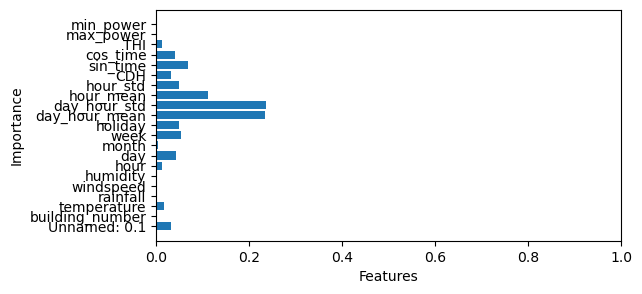

 26%|██▌       | 26/100 [01:43<04:06,  3.33s/it]

SMAPE: 13.383528215738815


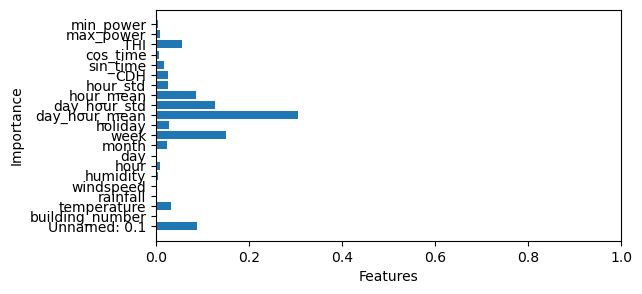

 27%|██▋       | 27/100 [01:46<03:59,  3.29s/it]

SMAPE: 5.945329996521081


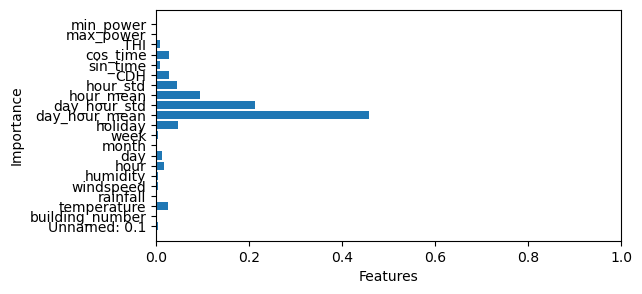

 28%|██▊       | 28/100 [01:47<03:13,  2.69s/it]

SMAPE: 13.53005530955156


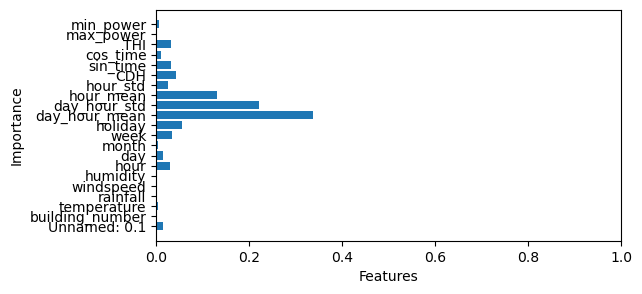

 29%|██▉       | 29/100 [01:48<02:39,  2.24s/it]

SMAPE: 16.337518712615154


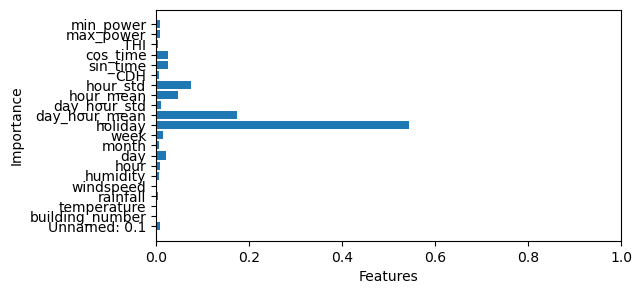

 30%|███       | 30/100 [01:55<04:07,  3.54s/it]

SMAPE: 10.212279980464471


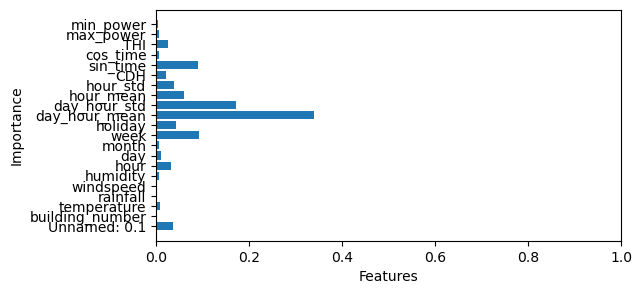

 31%|███       | 31/100 [01:57<03:43,  3.24s/it]

SMAPE: 2.2130672917230982


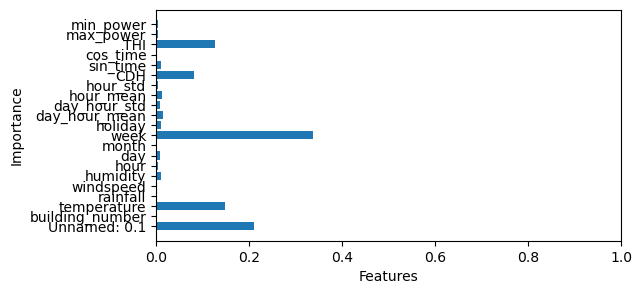

 32%|███▏      | 32/100 [02:02<04:02,  3.57s/it]

SMAPE: 3.320097464215874


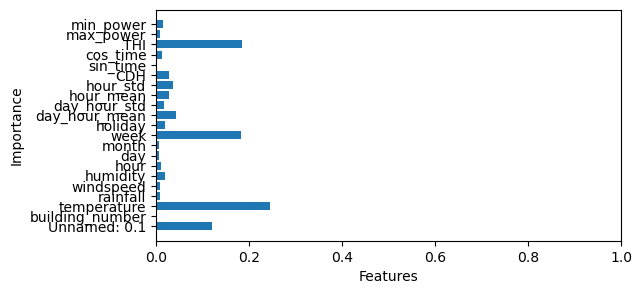

 33%|███▎      | 33/100 [02:03<03:15,  2.92s/it]

SMAPE: 3.919987027572054


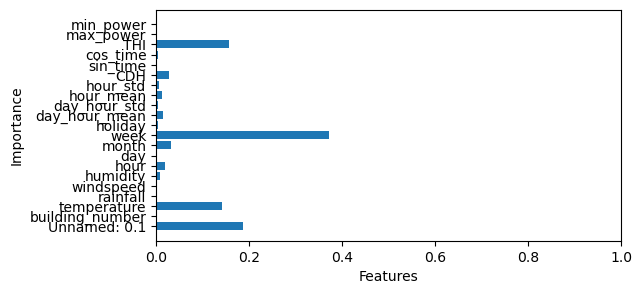

 34%|███▍      | 34/100 [02:07<03:39,  3.33s/it]

SMAPE: 2.367602649010491


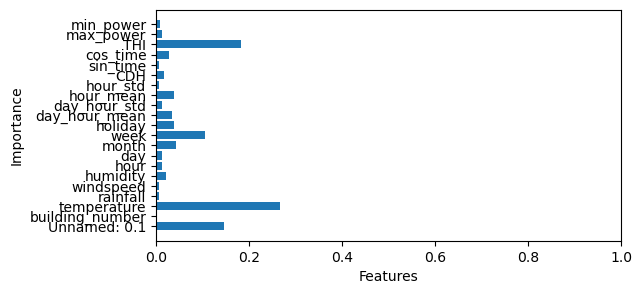

 35%|███▌      | 35/100 [02:12<04:00,  3.70s/it]

SMAPE: 0.6530803894951124


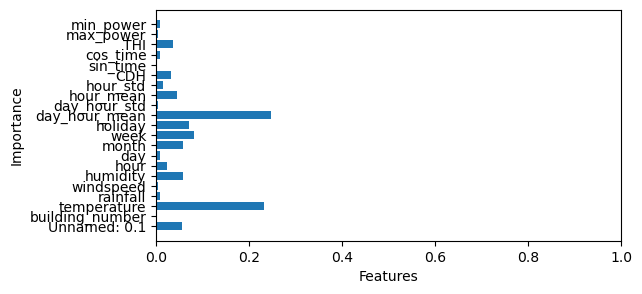

 36%|███▌      | 36/100 [02:19<05:03,  4.74s/it]

SMAPE: 7.939847813223685


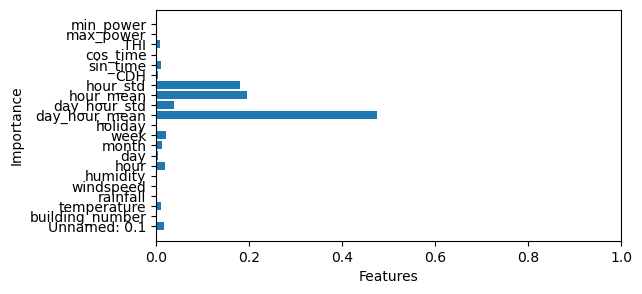

 37%|███▋      | 37/100 [02:23<04:38,  4.42s/it]

SMAPE: 13.973385237131943


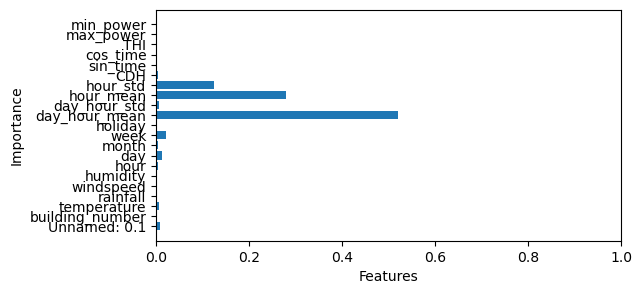

 38%|███▊      | 38/100 [02:31<05:42,  5.52s/it]

SMAPE: 7.6978362213209905


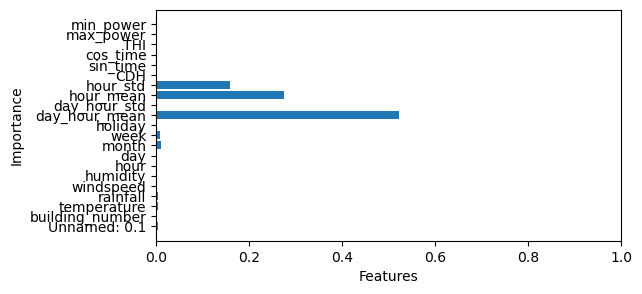

 39%|███▉      | 39/100 [02:39<06:20,  6.24s/it]

SMAPE: 15.471907126202131


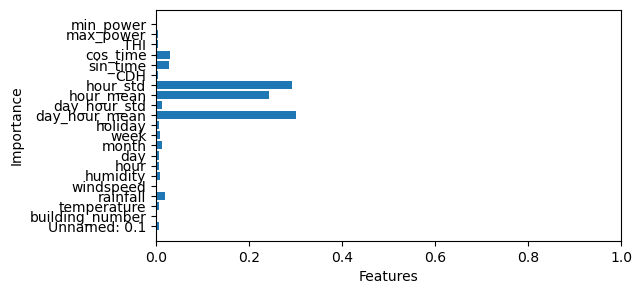

 40%|████      | 40/100 [02:42<05:19,  5.33s/it]

SMAPE: 9.396663821078935


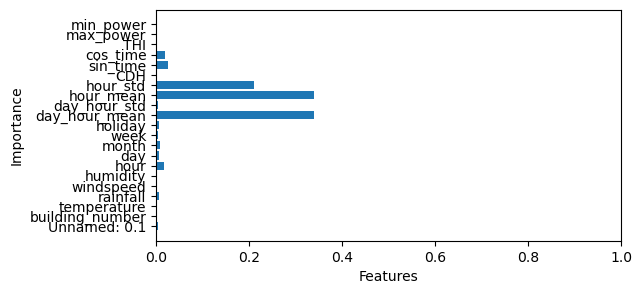

 41%|████      | 41/100 [02:47<05:09,  5.24s/it]

SMAPE: 14.345240302558352


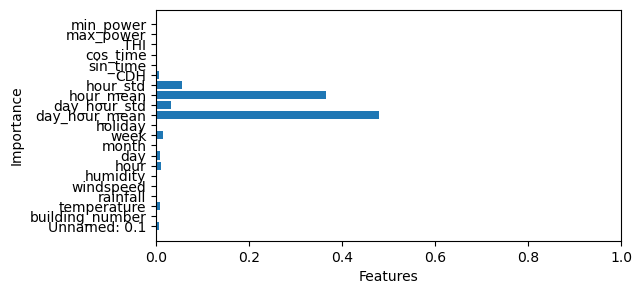

 42%|████▏     | 42/100 [02:52<05:06,  5.28s/it]

SMAPE: 13.238807069529033


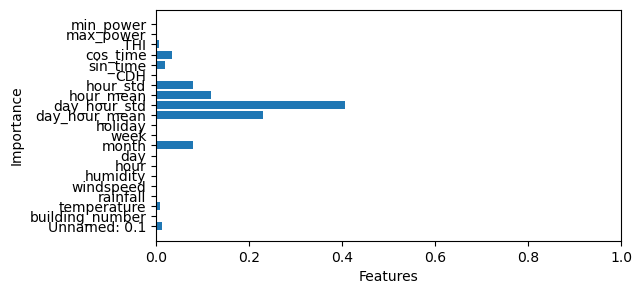

 43%|████▎     | 43/100 [02:56<04:30,  4.74s/it]

SMAPE: 6.373277025446177


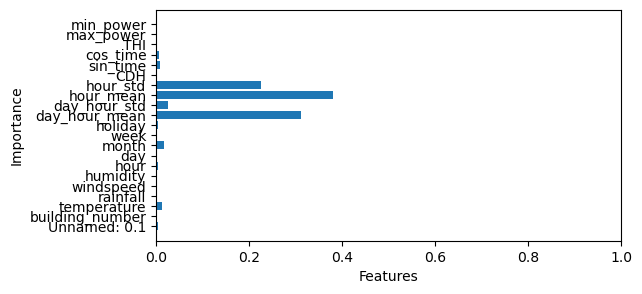

 44%|████▍     | 44/100 [03:00<04:16,  4.57s/it]

SMAPE: 12.353333197816736


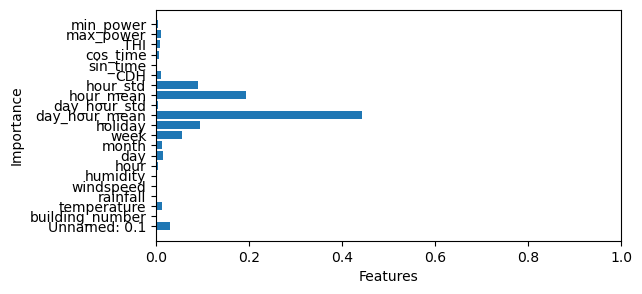

 45%|████▌     | 45/100 [03:05<04:19,  4.71s/it]

SMAPE: 21.372500613763254


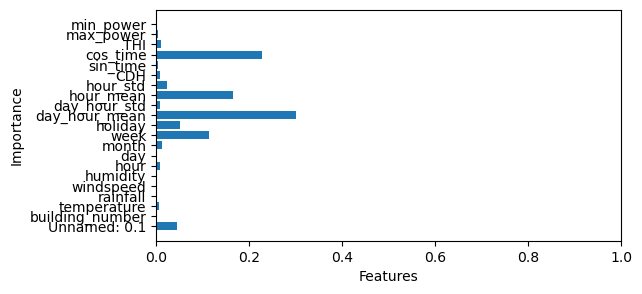

 46%|████▌     | 46/100 [03:08<03:48,  4.23s/it]

SMAPE: 15.242861742046983


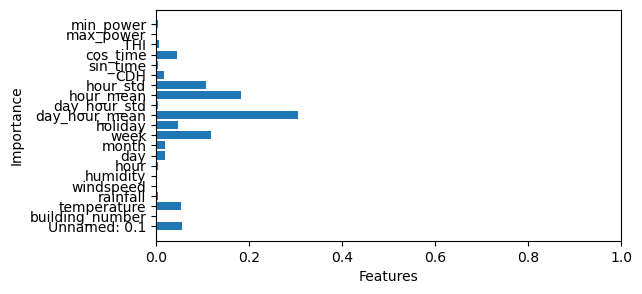

 47%|████▋     | 47/100 [03:11<03:17,  3.73s/it]

SMAPE: 14.12465865039992


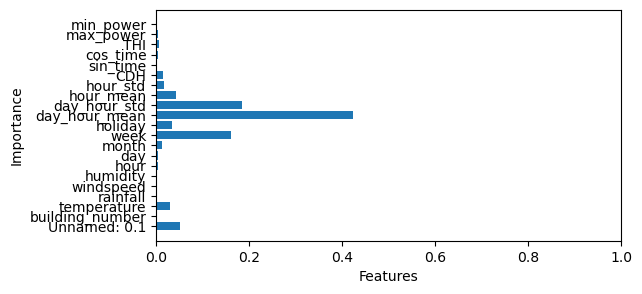

 48%|████▊     | 48/100 [03:15<03:12,  3.71s/it]

SMAPE: 11.827322940270115


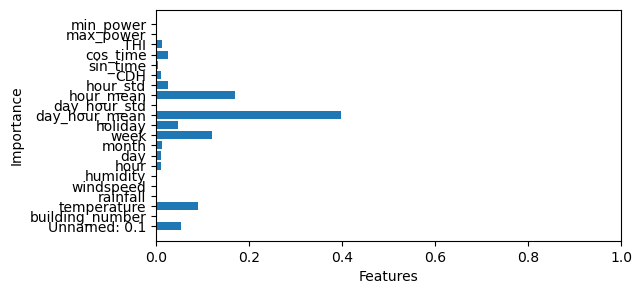

 49%|████▉     | 49/100 [03:20<03:38,  4.28s/it]

SMAPE: 18.36933061938281


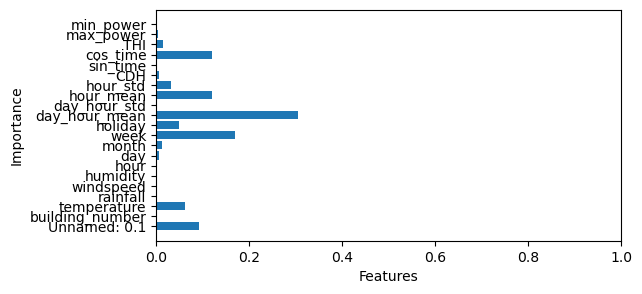

 50%|█████     | 50/100 [03:24<03:29,  4.19s/it]

SMAPE: 15.300581965206069


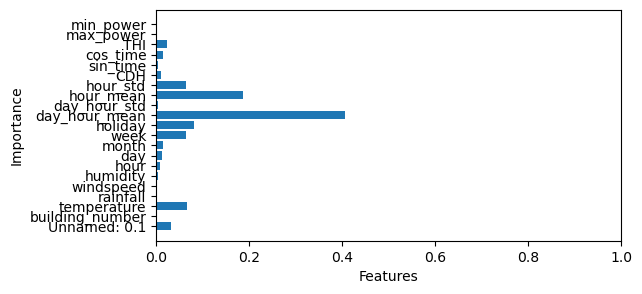

 51%|█████     | 51/100 [03:28<03:20,  4.10s/it]

SMAPE: 13.520216049950772


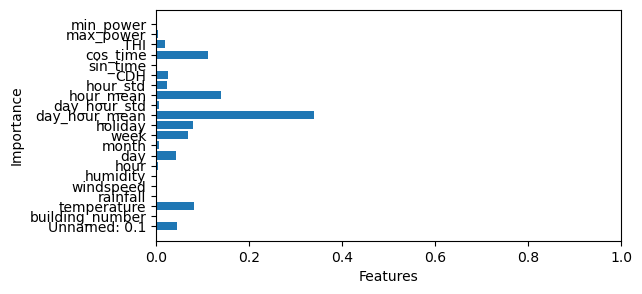

 52%|█████▏    | 52/100 [03:31<03:05,  3.87s/it]

SMAPE: 22.991555631815963


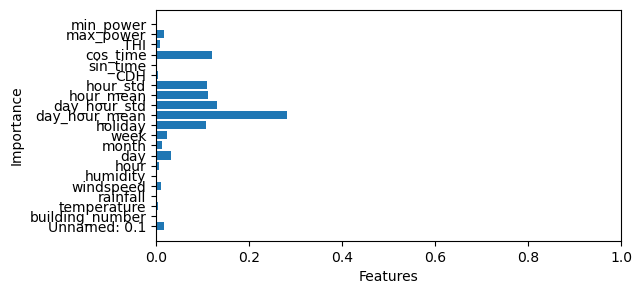

 53%|█████▎    | 53/100 [03:32<02:18,  2.95s/it]

SMAPE: 39.43511974752633


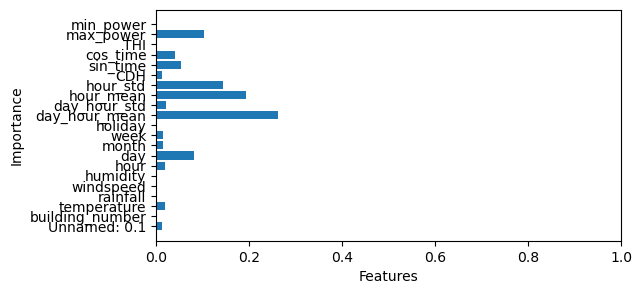

 54%|█████▍    | 54/100 [03:33<01:44,  2.27s/it]

SMAPE: 3.5829549401358847


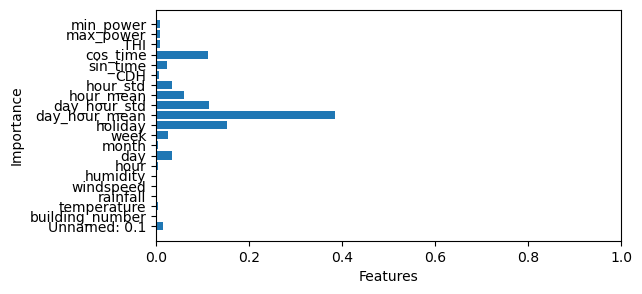

 55%|█████▌    | 55/100 [03:37<02:08,  2.85s/it]

SMAPE: 2.552635210365107


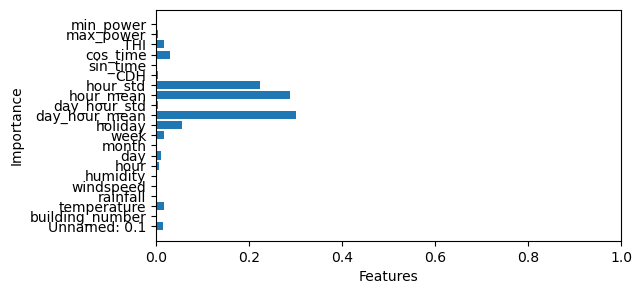

 56%|█████▌    | 56/100 [03:38<01:46,  2.42s/it]

SMAPE: 13.172410419970605


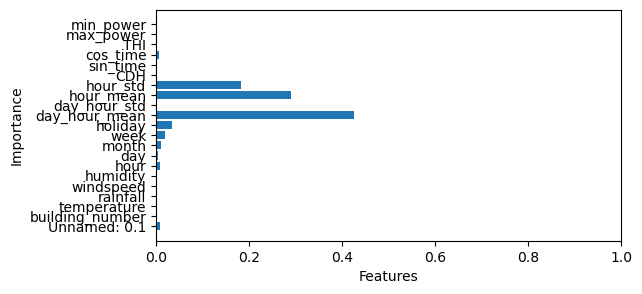

 57%|█████▋    | 57/100 [03:41<01:39,  2.32s/it]

SMAPE: 2.9133846230499696


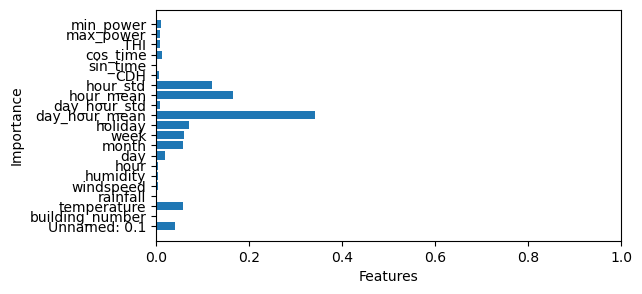

 58%|█████▊    | 58/100 [03:45<02:03,  2.95s/it]

SMAPE: 9.209642937906194


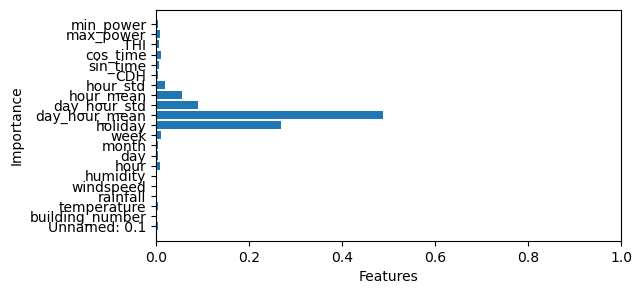

 59%|█████▉    | 59/100 [03:53<03:03,  4.47s/it]

SMAPE: 9.479370957779755


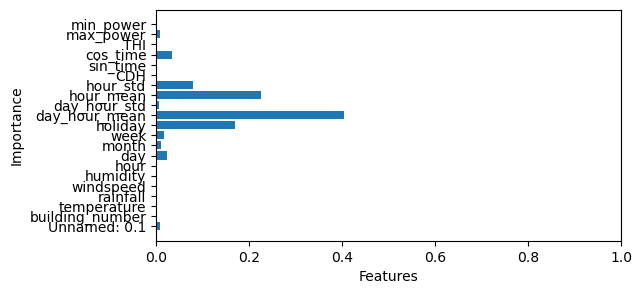

 60%|██████    | 60/100 [03:57<02:52,  4.30s/it]

SMAPE: 16.404447924775646


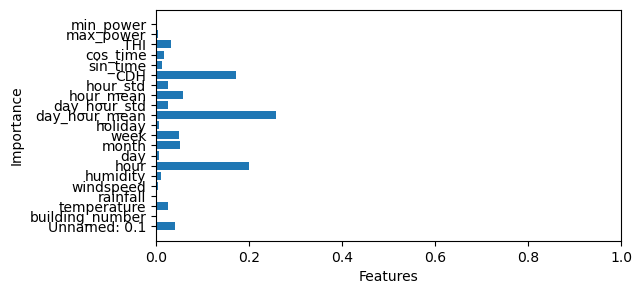

 61%|██████    | 61/100 [04:00<02:35,  3.98s/it]

SMAPE: 23.793594281672537


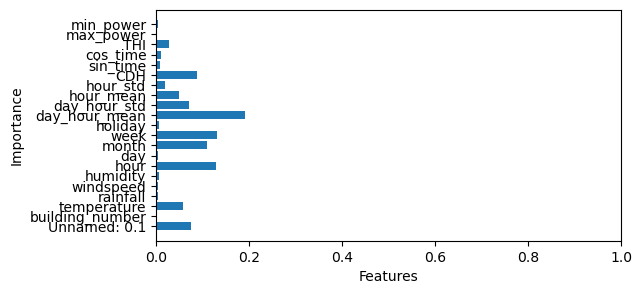

 62%|██████▏   | 62/100 [04:03<02:19,  3.68s/it]

SMAPE: 24.646437767872857


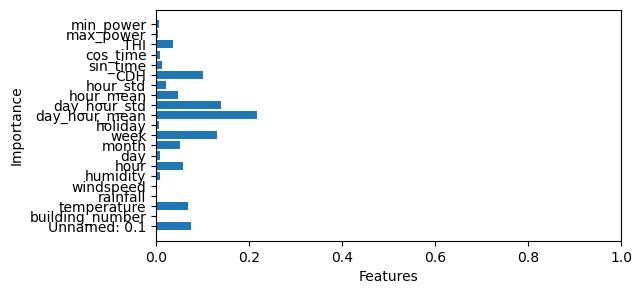

 63%|██████▎   | 63/100 [04:06<02:07,  3.45s/it]

SMAPE: 14.921606606243987


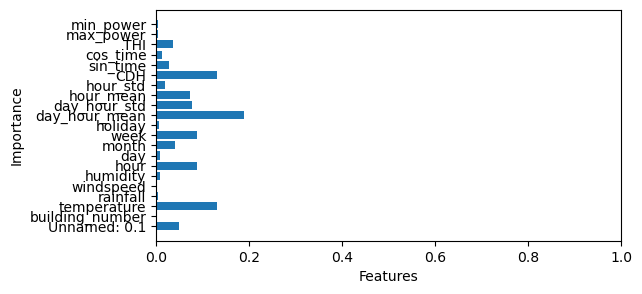

 64%|██████▍   | 64/100 [04:09<01:56,  3.25s/it]

SMAPE: 35.881339033064876


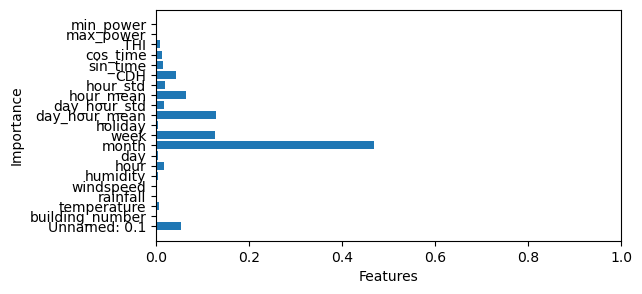

 65%|██████▌   | 65/100 [04:22<03:33,  6.10s/it]

SMAPE: 12.881653271548977


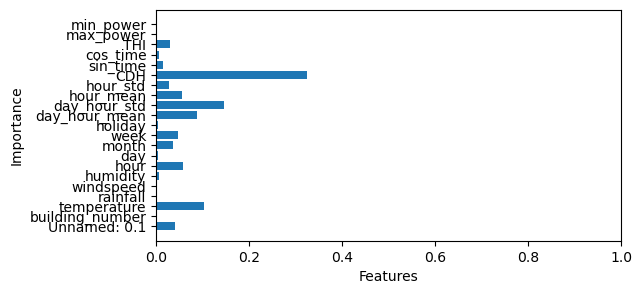

 66%|██████▌   | 66/100 [04:26<03:06,  5.48s/it]

SMAPE: 11.99641520855219


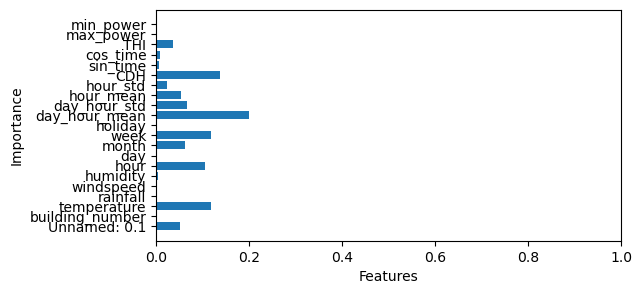

 67%|██████▋   | 67/100 [04:29<02:41,  4.90s/it]

SMAPE: 18.059268246495513


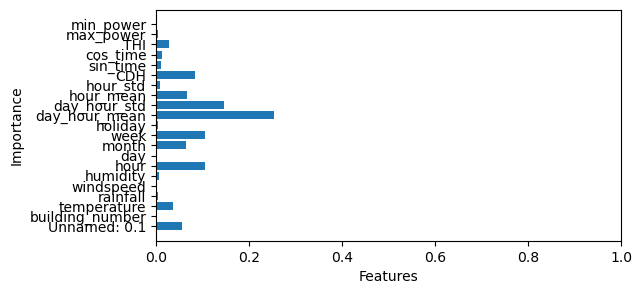

 68%|██████▊   | 68/100 [04:31<02:03,  3.86s/it]

SMAPE: 12.73077022390018


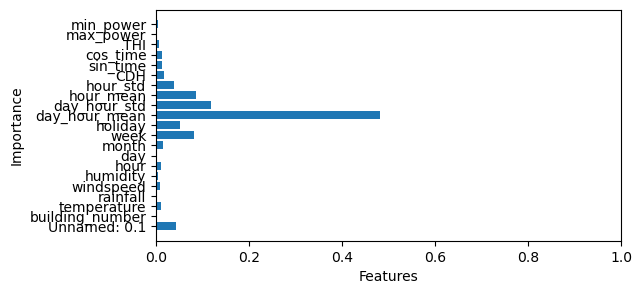

 69%|██████▉   | 69/100 [04:34<01:52,  3.64s/it]

SMAPE: 9.89777637764017


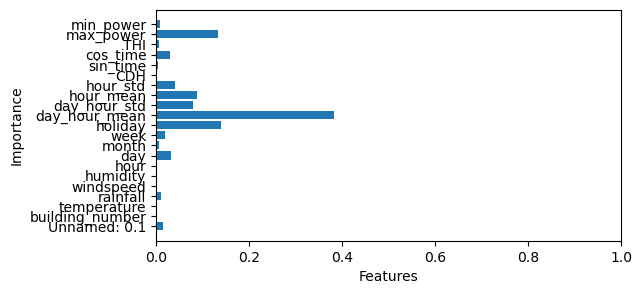

 70%|███████   | 70/100 [04:36<01:35,  3.19s/it]

SMAPE: 36.10869184758687


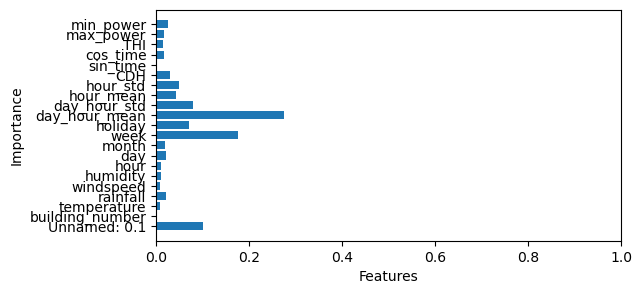

 71%|███████   | 71/100 [04:38<01:26,  2.98s/it]

SMAPE: 24.194636939546214


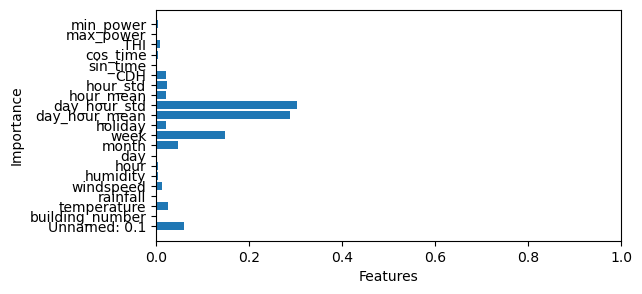

 72%|███████▏  | 72/100 [04:41<01:20,  2.87s/it]

SMAPE: 15.899134038185316


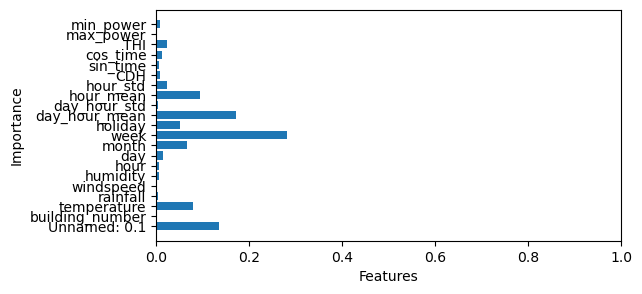

 73%|███████▎  | 73/100 [04:45<01:26,  3.20s/it]

SMAPE: 25.26654594319321


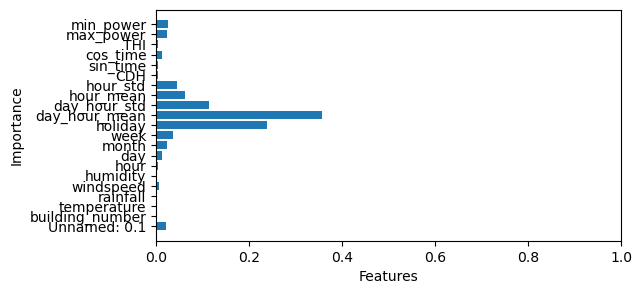

 74%|███████▍  | 74/100 [04:48<01:22,  3.17s/it]

SMAPE: 11.472924452894917


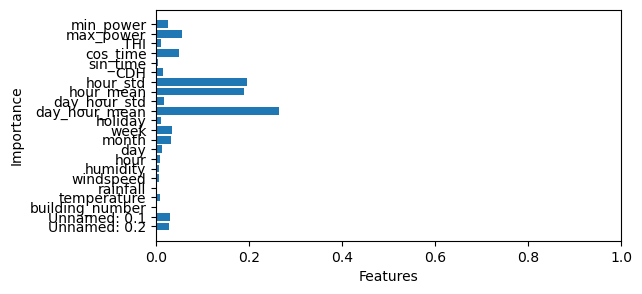

 75%|███████▌  | 75/100 [04:52<01:24,  3.37s/it]

SMAPE: 17.77182726798304


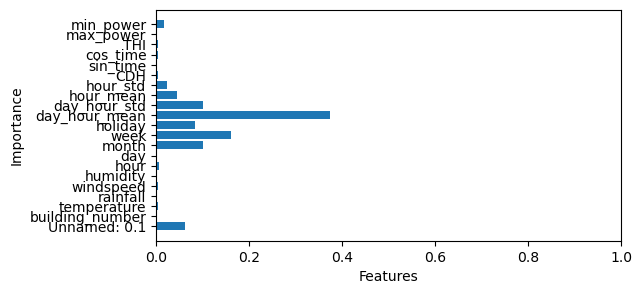

 76%|███████▌  | 76/100 [04:55<01:21,  3.38s/it]

SMAPE: 9.013718444262622


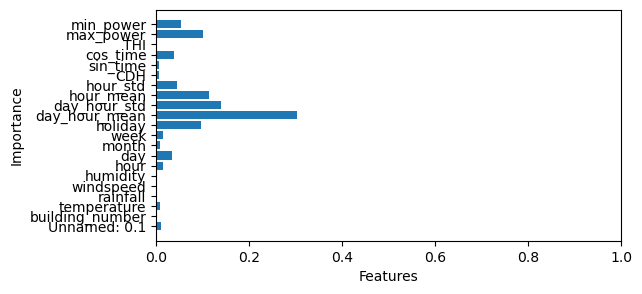

 77%|███████▋  | 77/100 [04:59<01:18,  3.42s/it]

SMAPE: 21.443079238476148


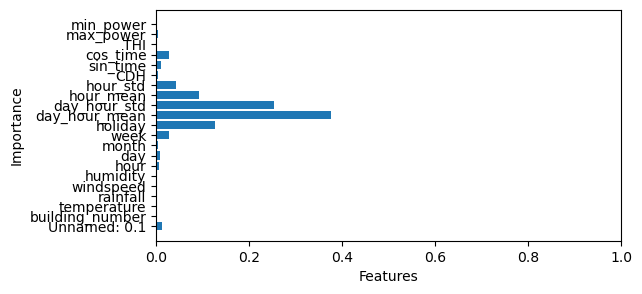

 78%|███████▊  | 78/100 [05:03<01:21,  3.71s/it]

SMAPE: 14.920252598795571


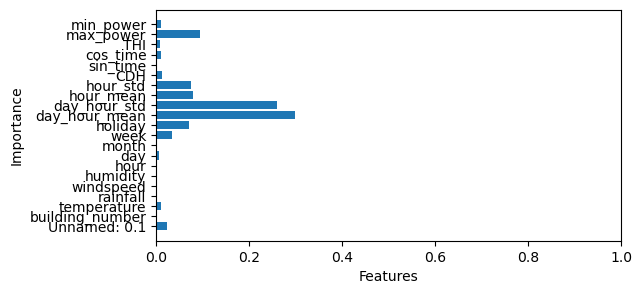

 79%|███████▉  | 79/100 [05:05<01:05,  3.12s/it]

SMAPE: 29.29079093439795


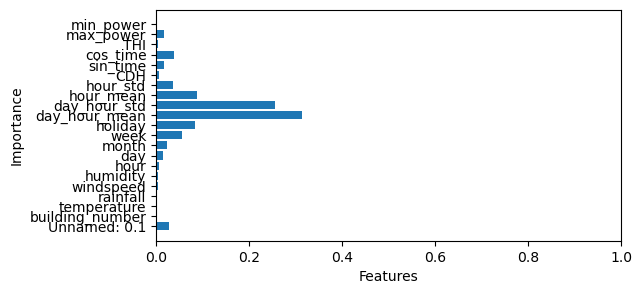

 80%|████████  | 80/100 [05:09<01:07,  3.37s/it]

SMAPE: 12.51726795582417


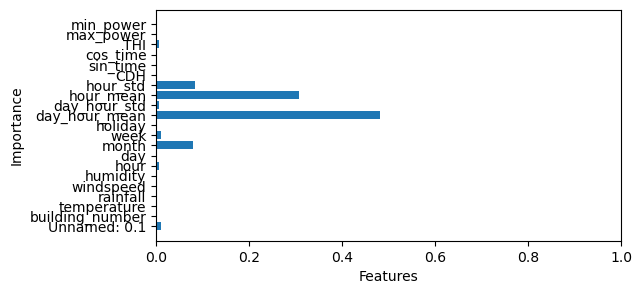

 81%|████████  | 81/100 [05:19<01:41,  5.36s/it]

SMAPE: 29.412961704565653


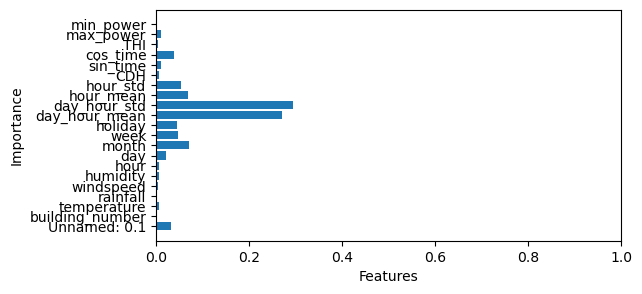

 82%|████████▏ | 82/100 [05:21<01:20,  4.48s/it]

SMAPE: 23.85423848350726


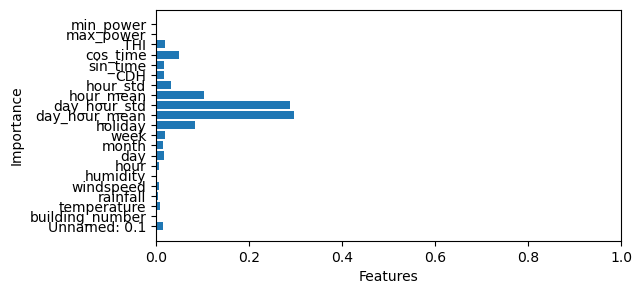

 83%|████████▎ | 83/100 [05:22<00:57,  3.41s/it]

SMAPE: 22.86614021171262


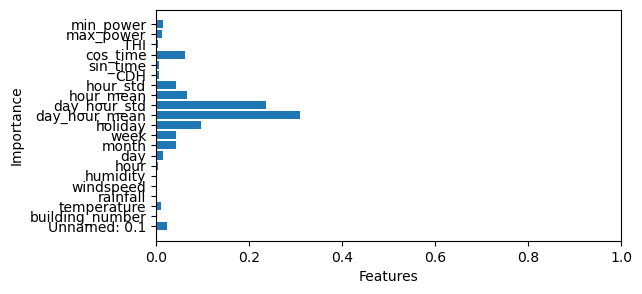

 84%|████████▍ | 84/100 [05:26<00:54,  3.39s/it]

SMAPE: 12.933626636165023


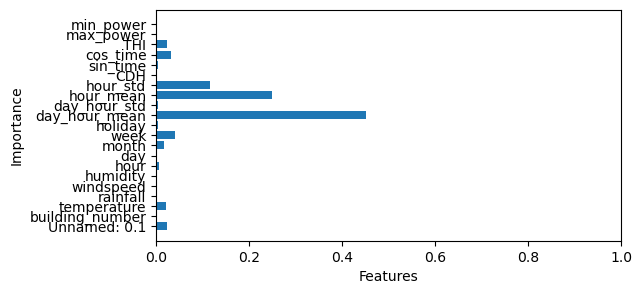

 85%|████████▌ | 85/100 [05:28<00:45,  3.05s/it]

SMAPE: 6.2341212839833124


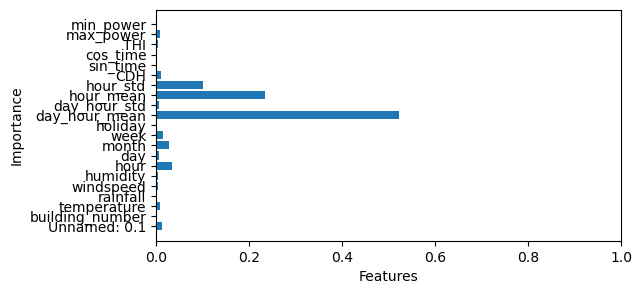

 86%|████████▌ | 86/100 [05:34<00:55,  3.99s/it]

SMAPE: 33.969689450640125


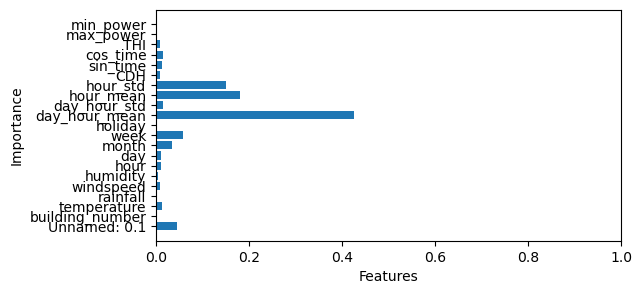

 87%|████████▋ | 87/100 [05:37<00:47,  3.65s/it]

SMAPE: 19.53266624820503


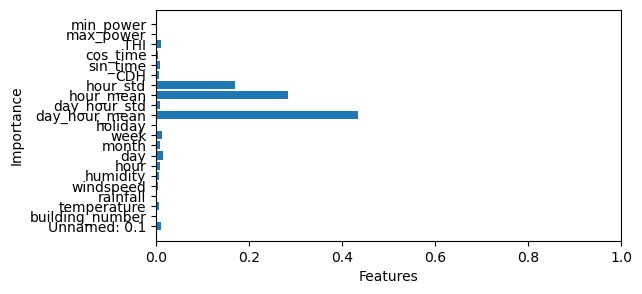

 88%|████████▊ | 88/100 [05:38<00:36,  3.06s/it]

SMAPE: 21.075809996678665


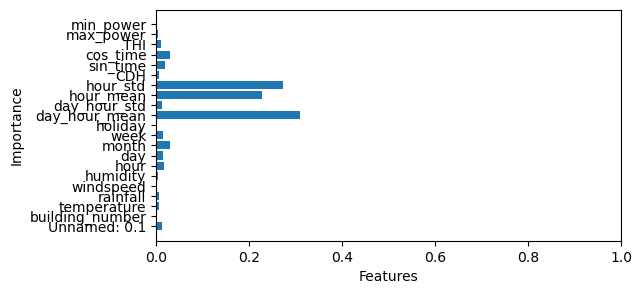

 89%|████████▉ | 89/100 [05:40<00:29,  2.64s/it]

SMAPE: 25.060834348780567


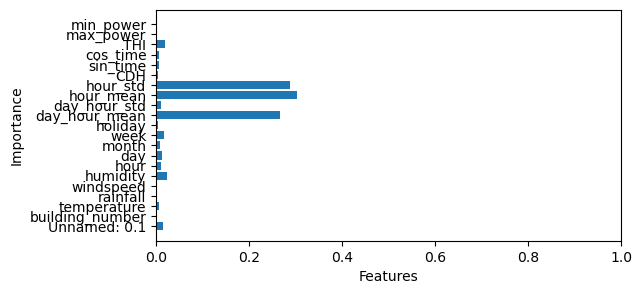

 90%|█████████ | 90/100 [05:43<00:26,  2.62s/it]

SMAPE: 17.065072560113773


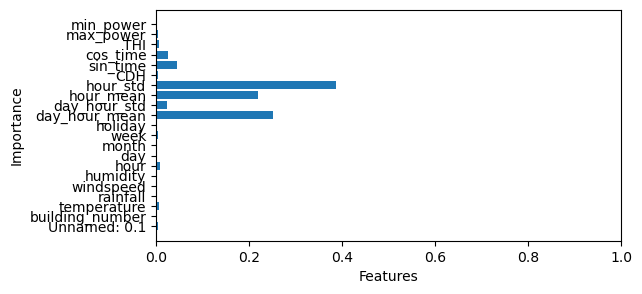

 91%|█████████ | 91/100 [05:45<00:23,  2.66s/it]

SMAPE: 10.412080292201594


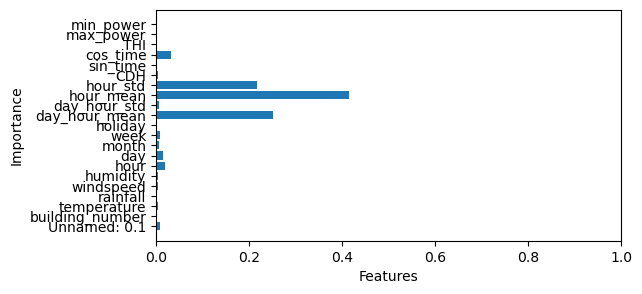

 92%|█████████▏| 92/100 [05:47<00:17,  2.18s/it]

SMAPE: 15.982832087576435


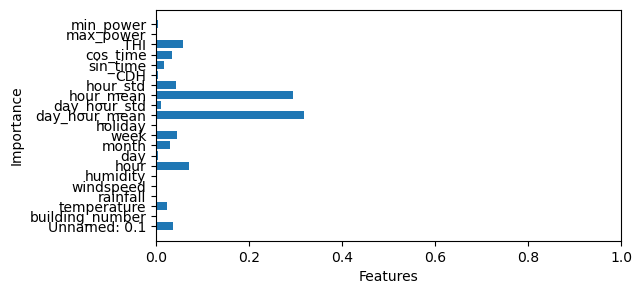

 93%|█████████▎| 93/100 [05:50<00:18,  2.66s/it]

SMAPE: 12.375658661736004


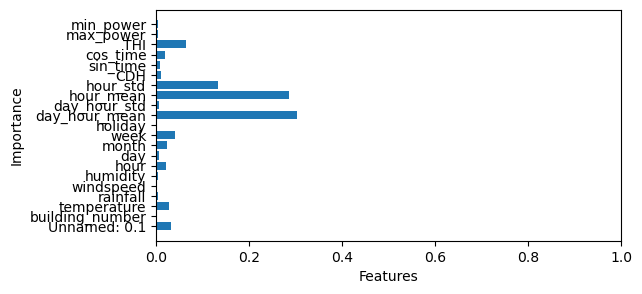

 94%|█████████▍| 94/100 [05:56<00:21,  3.61s/it]

SMAPE: 14.443665991809693


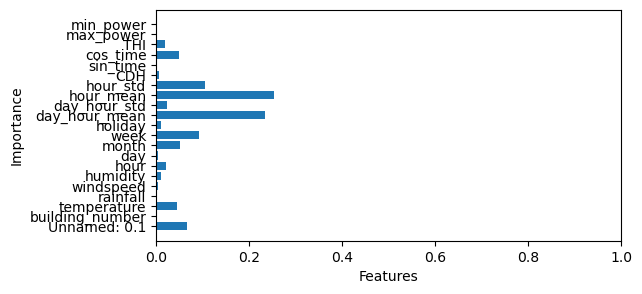

 95%|█████████▌| 95/100 [05:59<00:16,  3.25s/it]

SMAPE: 16.3119498121936


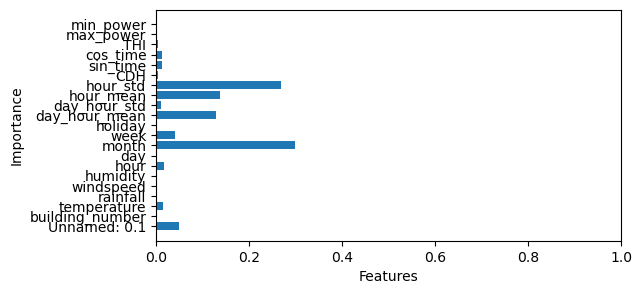

 96%|█████████▌| 96/100 [06:02<00:13,  3.32s/it]

SMAPE: 16.891262567183592


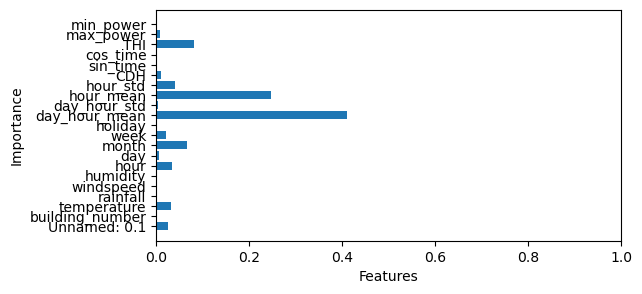

 97%|█████████▋| 97/100 [06:13<00:16,  5.47s/it]

SMAPE: 15.38187010982334


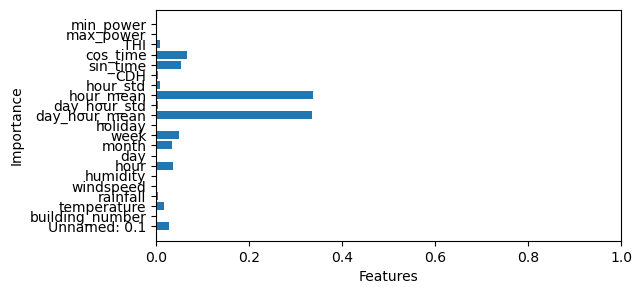

 98%|█████████▊| 98/100 [06:14<00:08,  4.36s/it]

SMAPE: 10.645864539680138


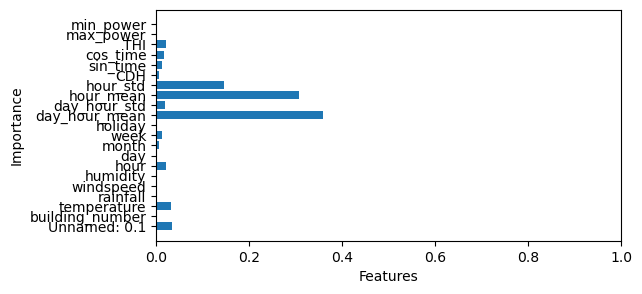

 99%|█████████▉| 99/100 [06:20<00:04,  4.67s/it]

SMAPE: 13.92930593577809


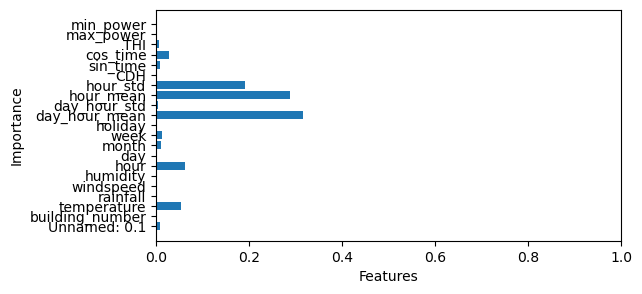

100%|██████████| 100/100 [06:22<00:00,  3.82s/it]


In [7]:
#smape점수 산출용
preds = np.array([])
smapes = []
missfit_building = []
hyper = pd.read_csv(f'./parameters/hyperparameter_xgb_lbw{t}.csv').drop(columns=['Unnamed: 0'])
for i in tqdm(range(100)):
    train_df = pd.read_csv(f'./pretest/2train_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    pretest_df = pd.read_csv(f'./pretest/2pretest_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    pred_df = pd.DataFrame()   # pretest 예측값을 담을 data frame
    
    feature_importances = []
    for seed in [0,1,2,3,4,5]: # 각 시드별 예측
        y_train = train_df['power_consumption']
        x_train = train_df.drop(columns=['power_consumption'])
        
        x_pretest = pretest_df.drop(columns=['power_consumption'])
        y_pretest = pretest_df['power_consumption']
        
        xgb = XGBRegressor(seed = seed, tree_method="hist", gpu_id=0,          
                           n_estimators = hyper.iloc[i,6], 
                           eta = hyper.iloc[i, 1],
                           min_child_weight = hyper.iloc[i, 2], max_depth = hyper.iloc[i, 3],
                           colsample_bytree=hyper.iloc[i, 4], subsample=hyper.iloc[i, 5])

        if hyper.iloc[i, 7] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
            xgb.set_params(**{'objective':weighted_mse(hyper.iloc[i,7])})

        xgb.fit(x_train, y_train)
        feature_importances.append(xgb.feature_importances_)
        y_pred = xgb.predict(x_pretest)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기
    
    pred = pred_df.mean(axis=1)   # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    pred_np = pred.to_numpy()
    y_pretest_np = y_pretest.to_numpy()
    score = SMAPE(y_pretest_np,pred_np) 
    preds = np.append(preds, pred)
    print("SMAPE:",score)
    average_feature_importances = np.mean(feature_importances, axis=0)
    plt.subplots(figsize=(6, 3))
    plt.barh(x_train.columns, average_feature_importances)
    plt.xlabel('Features')
    plt.xlim(0,1)
    plt.ylabel('Importance')
    plt.show()
    smapes.append(score)
    
    if score > 6:
        missfit_building.append(i)

In [ ]:
print(np.mean(smapes))

15.387055745631715
